In [1]:
Threads.nthreads()

128

In [2]:
push!(LOAD_PATH, "./")
using Plots
using Bspline
using FastGaussQuadrature
using LinearAlgebra
using WriteVTK
using eighth_rank_tensor
using Base.Threads
using BenchmarkTools

In [3]:
# 関数

# 点列ts上のB-splineの値
function Bs_value(p::Int64,k::Array{Float64,1},derivative::Int64,ts::Array{Float64,1})
    N = length(k)-p-1
    v = zeros(Float64,N,length(ts))
    for i in 1:N
        for j in 1:length(ts)
            v[i,j] = Ḃsn(derivative,i,p,k,ts[j])
        end
    end
    return v
end

# B-spline関数のリファインメント
function pref!(Pi::Array{Int64,1},P::Array{Int64,1},k::Array{Array{Float64,1},1})
    for d in 1:length(P)
        l = k[d][1]
        r = k[d][end]
        n = P[d]-Pi[d]
        prepend!(k[d],[l for i in 1:n])
        append!(k[d],[r for i in 1:n])
    end
end
function href!(P::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1})
    for d in 1:length(P)
        for i in 1:N[d]-P[d]-1
            insert!(k[d],P[d]+1+i,i/(N[d]-P[d]))
        end
    end
end

# IをI1,I2に分ける
function div_I_2d(I::Int64,N::Array{Int64,1})
    I1 = div(I-1,N[2])+1
    I2 = (I-1)%N[2]+1
    return I1,I2
end

# IをI1,I2,I3に分ける
function div_I_3d(I::Int64,N::Array{Int64,1})
    I1 = div(div(I-1,N[3]),N[2])+1
    I2 = div(I-1,N[3])%N[2]+1
    I3 = (I-1)%N[3]+1
    return I1,I2,I3
end

# idxをI,iに分ける
function div_idx(dim::Int64,idx::Int64)
    I = div(idx-1,dim)+1
    i = (idx-1)%dim+1
    return I,i
end

# ノット列の右端にノットを追加する
function add_knot!(p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},Nall::Int64,
        d₊::Int64,numk₊::Int64,border::Float64)
    for i in 1:p[d₊]+1
        pop!(k[d₊])
    end
    append!(k[d₊],[border+(1.0-border)*(i-1)/numk₊ for i in 1:numk₊])
    for i in 1:p[d₊]+1
        append!(k[d₊],1.0)
    end
    N[d₊] += numk₊
    Nall = prod([N[d] for d in 1:dim])
end

# 周期性条件
function periodic_condition!(p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        periodic_dim::Array{Int64,1})
    for pd in periodic_dim
        span = k[pd][p[pd]+2]-k[pd][1]
        for i in 1:p[pd]
            k[pd][i] = -span*(p[pd]+1-i)
            k[pd][end+1-i] = k[pd][end-p[pd]] + span*(p[pd]+1-i)
        end
    end
end

# ガウス積分点列,重み列を作る(1ノットスパンにつきnip個積分点をとる)
function make_Gauss(p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        nip::Array{Int64,1})
    dim = length(p)
    
    G = zeros(Int64,dim)
    for d in 1:dim
        G[d] = nip[d]*(N[d]-p[d])
    end
    
    tG = [zeros(Float64,G[d]) for d in 1:dim]
    wG = [zeros(Float64,G[d]) for d in 1:dim]
    
    for d in 1:dim
        for i in 1:N[d]-p[d]
            l = k[d][p[d]+i]
            r = k[d][p[d]+i+1]
        
            nodes,weights = gausslegendre(nip[d])
            nodes = nodes*(r-l)/2.0.+(l+r)/2.0
            weights = weights*(r-l)/2.0
        
            iG = (i-1)*nip[d]+1
            tG[d][iG:iG+nip[d]-1] .= nodes
            wG[d][iG:iG+nip[d]-1] .= weights
        end
    end
    return tG,wG,G
end

# Gauss積分点上のB-spline基底関数の値
function make_BsG!(dim::Int64,p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        Nall::Int64,periodic_dim::Array{Int64,1},tG::Array{Array{Float64,N} ,1} where N,
        wG::Array{Array{Float64,N} ,1} where N,G::Array{Int64,1})
    BsG = [zeros(Float64,N[d],G[d]) for d in 1:dim]
    BsG_t = [zeros(Float64,N[d],G[d]) for d in 1:dim]
    BsG_tt = [zeros(Float64,N[d],G[d]) for d in 1:dim]
    BsG_ttt = [zeros(Float64,N[d],G[d]) for d in 1:dim]
    for d in 1:dim
        BsG[d] = Bs_value(p[d],k[d],0,tG[d])
        BsG_t[d] = Bs_value(p[d],k[d],1,tG[d])
        BsG_tt[d] = Bs_value(p[d],k[d],2,tG[d])
        BsG_ttt[d] = Bs_value(p[d],k[d],3,tG[d])
    end
    
    # 周期性のある方向ではB-spline基底関数を次数個連結させる
    for pd in periodic_dim
        N[pd] = N[pd]-p[pd]
        Nall = prod([N[d] for d in 1:dim])
        
        BsG_new = [zeros(Float64,N[d],G[d]) for d in 1:dim]
        BsG_t_new = [zeros(Float64,N[d],G[d]) for d in 1:dim]
        BsG_tt_new = [zeros(Float64,N[d],G[d]) for d in 1:dim]
        BsG_ttt_new = [zeros(Float64,N[d],G[d]) for d in 1:dim]
        for i in 1:p[pd]
            BsG_new[pd][i,:] .= BsG[pd][i,:]+BsG[pd][N[pd]+i,:]
            BsG_t_new[pd][i,:] .= BsG_t[pd][i,:]+BsG_t[pd][N[pd]+i,:]
            BsG_tt_new[pd][i,:] .= BsG_tt[pd][i,:]+BsG_tt[pd][N[pd]+i,:]
            BsG_ttt_new[pd][i,:] .= BsG_ttt[pd][i,:]+BsG_ttt[pd][N[pd]+i,:]
        end
        for i in p[pd]+1:N[pd]
            BsG_new[pd][i,:] .= BsG[pd][i,:]
            BsG_t_new[pd][i,:] .= BsG_t[pd][i,:]
            BsG_tt_new[pd][i,:] .= BsG_tt[pd][i,:]
            BsG_ttt_new[pd][i,:] .= BsG_ttt[pd][i,:]
        end
        BsG[pd] = copy(BsG_new[pd])
        BsG_t[pd] = copy(BsG_t_new[pd])
        BsG_tt[pd] = copy(BsG_tt_new[pd])
        BsG_ttt[pd] = copy(BsG_ttt_new[pd])
    end
    return BsG,BsG_t,BsG_tt,BsG_ttt,N,Nall
end

# 評価点列，評価点列上のBsの値を返す
function make_BsE!(dim::Int64,p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        Nall::Int64,periodic_dim::Array{Int64,1},tEl::Array{Int64,1},flag_add_knot::Bool,
        d₊::Int64,numE₊::Int64,border::Float64)
    if dim==1
        tE = [collect(range(0,1,length=tEl[1])),[1],[1]]
    elseif dim==2
        tE = [collect(range(0,1,length=tEl[1])),collect(range(0,1,length=tEl[2])),[1]]
    elseif dim==3
        tE = [collect(range(0,1,length=tEl[1])),collect(range(0,1,length=tEl[2])),
                collect(range(0,1,length=tEl[3]))]
    end
    
    # 部分的にh-refinementしているとき
    if flag_add_knot
        pop!(tE[d₊])
        append!(tE[d₊],[border+(1.0-border)*(i-1)/numE₊ for i in 1:numE₊])
        append!(tE[d₊],1.0)
        tEl[d₊] += numE₊
    end
    
    # 値を代入
    BsE = [zeros(Float64,N[d],tEl[d]) for d in 1:dim]
    BsE_t = [zeros(Float64,N[d],tEl[d]) for d in 1:dim]
    BsE_tt = [zeros(Float64,N[d],tEl[d]) for d in 1:dim]
    BsE_ttt = [zeros(Float64,N[d],tEl[d]) for d in 1:dim]
    for d in 1:dim
        BsE[d] = Bs_value(p[d],k[d],0,tE[d])
        BsE_t[d] = Bs_value(p[d],k[d],1,tE[d])
        BsE_tt[d] = Bs_value(p[d],k[d],2,tE[d])
        BsE_ttt[d] = Bs_value(p[d],k[d],3,tE[d])
    end
    
    # 周期性のある方向では端を連結する
    for pd in periodic_dim
        BsE_new = [zeros(Float64,N[d],tEl[d]) for d in 1:dim]
        for i in 1:p[pd]
            BsE_new[pd][i,:] .= BsE[pd][i,:]+BsE[pd][N[pd]+i,:]
        end
        for i in p[pd]+1:N[pd]
            BsE_new[pd][i,:] .= BsE[pd][i,:]
        end
        BsE[pd] = copy(BsE_new[pd])
    end
    
    return tE,tEl,BsE,BsE_t,BsE_tt,BsE_ttt
end

# 評価点上の変位を求める
function calc_XE_uE_3d(dim::Int64,P::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},tE::Array{Array{Float64,1},1},tEl::Array{Int64,1},
        BsE::Array{Array{Float64,2},1},a0::Array{Array{Float64,1},1},uc::Array{Array{Float64,1},1})
    XE = zeros(Float64,3,tEl[1],tEl[2],tEl[3])
    uE = zeros(Float64,3,tEl[1],tEl[2],tEl[3])
    @threads for α in 1:tEl[1]*tEl[2]*tEl[3]
        iE1 = div(div(α-1,tEl[3]),tEl[2])+1
        iE2 = div(α-1,tEl[3])%tEl[2]+1
        iE3 = (α-1)%tEl[3]+1
        supp_basis_number1 = supp_basis_number(1,P,k,N,tE[1][iE1])
        supp_basis_number2 = supp_basis_number(2,P,k,N,tE[2][iE2])
        supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tE[3][iE3])
        for d in 1:dim
            for I1 in supp_basis_number1
                for I2 in supp_basis_number2
                    for I3 in supp_basis_number3
                        I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                        XE[d,iE1,iE2,iE3] += a0[d][I]*BsE[1][I1,iE1]*BsE[2][I2,iE2]*BsE[3][I3,iE3]
                        uE[d,iE1,iE2,iE3] += uc[d][I]*BsE[1][I1,iE1]*BsE[2][I2,iE2]*BsE[3][I3,iE3]
                    end
                end
            end
        end
    end
    return XE,uE
end

# 積分点上の変位を求める
function calc_XG_uG_3d(dim::Int64,P::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},G::Array{Int64,1},a0::Array{Array{Float64,1},1},uc::Array{Array{Float64,1},1},
        R::Array{Float64,4},R_x::Array{Float64,5},R_xx::Array{Float64,6},
        )
    XG = zeros(Float64,3,G[1],G[2],G[3])
    uG = zeros(Float64,3,G[1],G[2],G[3])
    u_xG = zeros(Float64,3,dim,G[1],G[2],G[3])
    u_xxG = zeros(Float64,3,dim,dim,G[1],G[2],G[3])

    @threads for α in 1:G[1]*G[2]*G[3]
        iG1 = div(div(α-1,G[3]),G[2])+1
        iG2 = div(α-1,G[3])%G[2]+1
        iG3 = (α-1)%G[3]+1
        supp_basis_number1 = supp_basis_number(1,P,k,N,tG[1][iG1])
        supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
        supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
        for I1 in supp_basis_number1
            for I2 in supp_basis_number2
                for I3 in supp_basis_number3
                    I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                    for i in 1:dim
                        XG[i,iG1,iG2,iG3] += a0[i][I]*R[I,iG1,iG2,iG3]
                        uG[i,iG1,iG2,iG3] += uc[i][I]*R[I,iG1,iG2,iG3]
                        for j in 1:dim
                            u_xG[i,j,iG1,iG2,iG3] += uc[i][I]*R_x[I,j,iG1,iG2,iG3]
                            for k in 1:dim
                                u_xxG[i,j,k,iG1,iG2,iG3] += uc[i][I]*R_xx[I,j,k,iG1,iG2,iG3]
                            end
                        end
                    end
                end
            end
        end
    end
    return XG,uG,u_xG,u_xxG
end

# 法線ベクトル方向の積分点上の変位を求める
function calc_unG_3d(dim::Int64,P::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},G::Array{Int64,1},a0::Array{Array{Float64,1},1},uc::Array{Array{Float64,1},1},
        R::Array{Float64,4},R_x::Array{Float64,5},R_xx::Array{Float64,6},normal::Array{Float64,3}
        )
    unG = zeros(Float64,G[1],G[2],G[3])

    @threads for α in 1:G[1]*G[2]*G[3]
        iG1 = div(div(α-1,G[3]),G[2])+1
        iG2 = div(α-1,G[3])%G[2]+1
        iG3 = (α-1)%G[3]+1
        supp_basis_number1 = supp_basis_number(1,P,k,N,tG[1][iG1])
        supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
        supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
        for I1 in supp_basis_number1
            for I2 in supp_basis_number2
                for I3 in supp_basis_number3
                    I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                    for i in 1:dim
                        unG[iG1,iG2,iG3] += uc[i][I]*R[I,iG1,iG2,iG3]*normal[i,iG2,iG3]
                    end
                end
            end
        end
    end
    return unG
end

# 同方向の2つの基底関数が重なる範囲の番号を配列で返す
function supp_Bs_double(i::Int64,d::Int64,p::Array{Int64,1},N::Array{Int64,1})
    i-p[d]>1 ? l=i-p[d] : l=1
    i+p[d]<N[d] ? r=i+p[d] : r=N[d]
    range = Vector(l:r)
    return range
end

# 同方向の2つの基底関数が重なる範囲の番号を配列で返す(周期性あり)
function supp_Bs_double_periodic(i::Int64,d::Int64,p::Array{Int64,1},N::Array{Int64,1})
    i-p[d]>1 ? l=i-p[d] : l=1
    i+p[d]<N[d] ? r=i+p[d] : r=N[d]
    range = Vector(l:r)
    
    if i <= p[d]
        plus = Vector(N[d]-(p[d]-i):N[d])
        range = unique(vcat(range,plus))
    end
    if i >= N[d]-p[d]+1
        plus = Vector(1:i-N[d]+p[d])
        range = unique(vcat(range,plus))
    end
    sort!(range)
    return range
end

# 同方向の2つの基底関数が重なる範囲のガウス積分点の番号を配列で返す
function supp_Gauss_double(i::Int64,j::Int64,d::Int64,p::Array{Int64,1},G::Array{Int64,1},
        nip::Array{Int64,1})
    if i < j
        l = (j-p[d]-1)*nip[d]+1
        r = i*nip[d]
    else
        l = (i-p[d]-1)*nip[d]+1
        r = j*nip[d]
    end
    if l < 1
        l = 1
    end
    if r > G[d]
        r = G[d]
    end
    range = Vector(l:r)
    return range
end

# 同方向の2つの基底関数が重なる範囲のガウス積分点の番号を配列で返す（周期性あり）
function supp_Gauss_double_periodic(i::Int64,j::Int64,d::Int64,p::Array{Int64,1},G::Array{Int64,1},
        nip::Array{Int64,1})
    if i < j
        l = (j-p[d]-1)*nip[d]+1
        r = i*nip[d]
        if l < 1
            l = 1
        end
        if r > G[d]
            r = G[d]
        end
        range = Vector(l:r)
        if i <= p[d]
            l = G[d]-(p[d]-i+1)*nip[d]+1
            if j <= p[d]
                l = G[d]-(p[d]-j+1)*nip[d]+1
                r = G[d]
            else
                r = j*nip[d]
            end
            plus = Vector(l:r)
            range = vcat(range,plus)
        end
    else
        l = (i-p[d]-1)*nip[d]+1
        r = j*nip[d]
        if l < 1
            l = 1
        end
        if r > G[d]
            r = G[d]
        end
        range = Vector(l:r)
        if j <= p[d]
            l = G[d]-(p[d]-j+1)*nip[d]+1
            if i <= p[d]
                l = G[d]-(p[d]-i+1)*nip[d]+1
                r = G[d]
            else
                r = i*nip[d]
            end
            plus = Vector(l:r)
            range = vcat(range,plus)
        end
    end
    return range
end

# 台に含まれるガウス積分点の番号を配列で返す
function supp_Gauss_single(i::Int64,d::Int64,p::Array{Int64,1},G::Array{Int64,1},nip::Array{Int64,1})
    l = (i-p[d]-1)*nip[d]+1
    r = i*nip[d]
    if l<1
        l = 1
    end
    if r>G[d]
        r = G[d]
    end
    range = Vector(l:r)
    return range
end

# 台に含まれるガウス積分点の番号を配列で返す（周期性あり）
function supp_Gauss_single_periodic(i::Int64,d::Int64,p::Array{Int64,1},G::Array{Int64,1},
        nip::Array{Int64,1})
    l = (i-p[d]-1)*nip[d]+1
    r = i*nip[d]
    if l<1
        l = 1
    end
    if r>G[d]
        r = G[d]
    end
    range = Vector(l:r)
    if i<=p[d]
        l = G[d]-(p[d]-i+1)*nip[d]+1
        r = G[d]
        plus = Vector(l:r)
        range = vcat(range,plus)
    end
    return range
end

# 与えられた点(0~1)を含むB-spline基底関数の番号の範囲を配列で返す
function supp_basis_number(d::Int64,p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        t::Float64)
    beg = 0
    en = 0
    for i in 1:N[d]
        if k[d][i]<=t<=k[d][i+1]
            beg = i-p[d]
            en = i
            if beg<1
                beg = 1
            end
            range = Vector(beg:en)
            return range
        end
    end
end

# 与えられた積分点，評価点を含むB-spline基底関数の番号の範囲を配列で返す（周期性あり）
function supp_basis_number_periodic(d::Int64,p::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},t::Float64)
    beg = 0
    en = 0
    for i in p[d]+1:N[d]+p[d]
        if k[d][i]<=t<=k[d][i+1]
            beg = i-p[d]
            en = i
            range = Vector(beg:en)
            if en>N[d]
                en = N[d]
                range = Vector(beg:en)
                
                beg_plus = 1
                en_plus = i-N[d]
                plus = Vector(beg_plus:en_plus)
                range = vcat(plus,range)
            end
            return range
        end
    end
end

# 円環のフィッティング
function fitting_annulus(dim::Int64,p::Array{Int64,1},k::Array{Array{Float64,1},1},N::Array{Int64,1},
        Nall::Int64,nip::Array{Int64,1},tG::Array{Array{Float64,1},1},
        wG::Array{Array{Float64,1},1},G::Array{Int64,1},BsG::Array{Array{Float64,2},1},
        R_outside::Float64)
    r1 = R_outside/2.0
    r2 = R_outside
    r(t1) = r1+(r2-r1)*t1
    θ(t2) = 2.0*π*t2
    x = [zeros(Float64,G[1],G[2]) for d in 1:dim]
    for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            x[1][iG1,iG2] = r(tG[1][iG1])*cos(θ(tG[2][iG2]))
            x[2][iG1,iG2] = r(tG[1][iG1])*sin(θ(tG[2][iG2]))
        end
    end
    
    # 剛性行列
    M = zeros(Float64,Nall,Nall)
    for I1 in 1:N[1]
        supp_Bs1 = supp_Bs_double(I1,1,p,N)
        for I2 in 1:N[2]
            supp_Bs2 = supp_Bs_double_periodic(I2,2,p,N)
            I = (I1-1)*N[2]+I2
            for J1 in supp_Bs1
                supp_Gauss1 = supp_Gauss_double(I1,J1,1,p,G,nip)
                for J2 in supp_Bs2
                    supp_Gauss2 = supp_Gauss_double_periodic(I2,J2,2,p,G,nip)
                    J = (J1-1)*N[2]+J2
                    if I < J
                        break
                    end
                    
                    c1 = 0.0
                    for iG1 in supp_Gauss1
                        c1 += wG[1][iG1]*BsG[1][I1,iG1]*BsG[1][J1,iG1]
                    end
                    c2 = 0.0
                    for iG2 in supp_Gauss2
                        c2 += wG[2][iG2]*BsG[2][I2,iG2]*BsG[2][J2,iG2]
                    end
                    
                    M[I,J] = c1*c2
                    M[J,I] = M[I,J]
                end
            end
        end
    end
    
    # 右辺ベクトル
    f = [zeros(Float64,Nall) for d in 1:dim]
    for I1 in 1:N[1]
        supp_Gauss1 = supp_Gauss_single(I1,1,p,G,nip)
        for I2 in 1:N[2]
            supp_Gauss2 = supp_Gauss_single_periodic(I2,2,p,G,nip)
            I = (I1-1)*N[2]+I2
            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    f[1][I] += wG[1][iG1]*wG[2][iG2]*BsG[1][I1,iG1]*BsG[2][I2,iG2]*x[1][iG1,iG2]
                    f[2][I] += wG[1][iG1]*wG[2][iG2]*BsG[1][I1,iG1]*BsG[2][I2,iG2]*x[2][iG1,iG2]
                end
            end
        end
    end
    
    # 制御点を求める
    a = [zeros(Float64,Nall) for d in 1:dim]
    for d in 1:dim
        a[d] = M\f[d]
    end
    
    return a
end

# 球殻のフィッティング
function fitting_spherical_shell(dim::Int64,P::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},tG::Array{Array{Float64,1},1},
        wG::Array{Array{Float64,1},1},G::Array{Int64,1},BsG::Array{Array{Float64,2},1},
        R_outside::Float64,R_ratio::Float64)
    r1 = R_outside*R_ratio
    r2 = R_outside
    r(t1) = r1+(r2-r1)*t1
    θ(t2) = π*t2
    ϕ(t3) = 2*π*t3
    x = [zeros(Float64,G[1],G[2],G[3]) for d in 1:dim]
    for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            for iG3 in 1:G[3]
                x[1][iG1,iG2,iG3] = r(tG[1][iG1])*sin(θ(tG[2][iG2]))*cos(ϕ(tG[3][iG3]))
                x[2][iG1,iG2,iG3] = r(tG[1][iG1])*sin(θ(tG[2][iG2]))*sin(ϕ(tG[3][iG3]))
                x[3][iG1,iG2,iG3] = r(tG[1][iG1])*cos(θ(tG[2][iG2]))
            end
        end
    end
    
    # 剛性行列
    M = zeros(Float64,Nall,Nall)
    for I1 in 1:N[1]
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        for I2 in 1:N[2]
            supp_Bs2 = supp_Bs_double(I2,2,P,N)
            for I3 in 1:N[3]
                supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                for J1 in supp_Bs1
                    supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
                    for J2 in supp_Bs2
                        supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                        for J3 in supp_Bs3
                            supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                            J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                            if I < J
                                break
                            end 
                            c1 = sum(wG[1][iG1]*BsG[1][I1,iG1]*BsG[1][J1,iG1] for iG1 in supp_Gauss1)
                            c2 = sum(wG[2][iG2]*BsG[2][I2,iG2]*BsG[2][J2,iG2] for iG2 in supp_Gauss2)
                            c3 = sum(wG[3][iG3]*BsG[3][I3,iG3]*BsG[3][J3,iG3] for iG3 in supp_Gauss3)
                            M[I,J] = c1*c2*c3
                            M[J,I] = M[I,J]
                        end
                    end
                end
            end
        end
    end
    
    # 右辺ベクトル
    f = [zeros(Float64,Nall) for d in 1:dim]
    for I1 in 1:N[1]
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        for I2 in 1:N[2]
            supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
            for I3 in 1:N[3]
                supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                for iG1 in supp_Gauss1
                    for iG2 in supp_Gauss2
                        for iG3 in supp_Gauss3
                            c1 = wG[1][iG1]*wG[2][iG2]*wG[3][iG3]*
                                BsG[1][I1,iG1]*BsG[2][I2,iG2]*BsG[3][I3,iG3]
                            f[1][I] += c1*x[1][iG1,iG2,iG3]
                            f[2][I] += c1*x[2][iG1,iG2,iG3]
                            f[3][I] += c1*x[3][iG1,iG2,iG3]
                        end
                    end
                end
            end
        end
    end
    
    # 制御点を求める
    a = [zeros(Float64,Nall) for d in 1:dim]
    for d in 1:dim
        a[d] = M\f[d]
    end
    
    return a
end

# 古典弾性体の弾性定数 C,nonzero_C
function makeδ_Classical_constant(λ::Float64,μ::Float64,dim::Int64)
    if dim==2
        δ = [1.0 0.0
             0.0 1.0]
    elseif dim==3
        δ = [1.0 0.0 0.0
             0.0 1.0 0.0
             0.0 0.0 1.0]
    end
    C = zeros(Float64,dim,dim,dim,dim)
    list_nzero= zeros(Int64,dim^4)
    cnt=1
    for i in 1:dim
        for j in 1:dim
            for k in 1:dim
                for l in 1:dim
                    α = dim^3*(i-1) + dim^2*(j-1) + dim^1*(k-1) + l
                    C[i,j,k,l] = λ*δ[i,j]*δ[k,l]+μ*(δ[i,k]*δ[j,l]+δ[i,l]*δ[j,k])
                    if C[i,j,k,l] !=0.0
                        list_nzero[cnt] = α
                        cnt+=1
                    end
                end
            end
        end
    end
    list_nzero = list_nzero[list_nzero.>0]
    return δ,C,list_nzero
end

# FSGの弾性定数 A6,B,nonzero_A6,nonzero_B
function makeFSG_constant(a1::Float64,b2::Float64,dim::Int64)
    A6 = zeros(Float64,dim,dim,dim,dim,dim,dim)
    B = zeros(Float64,dim,dim,dim,dim,dim,dim)
    list_nzero = zeros(Int64,dim^6)
    
    cnt = 1
    for i in 1:dim
        for j in 1:dim
            for k in 1:dim
                for l in 1:dim
                    for m in 1:dim
                        for n in 1:dim
                            α = dim^5*(i-1) + dim^4*(j-1) + dim^3*(k-1) + 
                                dim^2*(l-1) + dim^1*(m-1) + n
                            D1 = zeros(Float64,5)
                            D1[1] = (delta(i,n)*delta(j,k)*delta(l,m)+delta(i,k)*delta(j,n)*
                                    delta(l,m)+delta(i,j)*delta(k,m)*delta(l,n)+delta(i,j)*
                                    delta(k,l)*delta(m,n))
                            D1[2] = delta(i,j)*delta(k,n)*delta(l,m)
                            D1[3] = (delta(i,m)*delta(j,k)*delta(l,n)+delta(i,k)*delta(j,m)*
                                    delta(l,n)+delta(i,l)*delta(j,k)*delta(m,n)+delta(i,k)*
                                    delta(j,l)*delta(m,n))
                            D1[4] = delta(i,m)*delta(j,l)*delta(k,n) + delta(i,l)*delta(j,m)*delta(k,n)
                            D1[5] = (delta(i,n)*delta(j,m)*delta(k,l)+delta(i,m)*delta(j,n)*
                                    delta(k,l)+delta(i,n)*delta(j,l)*delta(k,m)+delta(i,l)*
                                    delta(j,n)*delta(k,m))
                            for β in 1:5
                                A6[i,j,k,l,m,n] += a1/15.0*D1[β]
                                B[i,j,k,l,m,n] += b2/15.0*D1[β]
                            end
                            if A6[i,j,k,l,m,n] != 0.0
                                list_nzero[cnt] = α
                                cnt += 1
                            end
                        end
                    end
                end
            end
        end
    end
    list_nzero = list_nzero[list_nzero.>0]
    list_nzero_A6 = copy(list_nzero)
    list_nzero_B = copy(list_nzero)
    return A6,B,list_nzero_A6,list_nzero_B
end

# 添字の通し番号を分解する
function make_base_list(base_num::Int64,dim::Int64)
    baselist = [zeros(Int64,base_num) for i in 1:dim^base_num]
    if base_num==4
        for α in 1:dim^4
            p = div((α-1),dim^3)+1
            q = div((α-1)%dim^3,dim^2)+1
            r = div((α-1)%dim^3%dim^2,dim^1)+1
            s = div((α-1)%dim^3%dim^2%dim^1,dim^0)+1
            baselist[α] = [p,q,r,s]
        end
    end
    if base_num==6
        for α in 1:dim^6
            p = div((α-1),dim^5)+1
            q = div((α-1)%dim^5,dim^4)+1
            r = div((α-1)%dim^5%dim^4,dim^3)+1
            s = div((α-1)%dim^5%dim^4%dim^3,dim^2)+1
            t = div((α-1)%dim^5%dim^4%dim^3%dim^2,dim^1)+1
            u = div((α-1)%dim^5%dim^4%dim^3%dim^2%dim^1,dim^0)+1
            baselist[α] = [p,q,r,s,t,u]
        end
    end
    if base_num==8
        for α in 1:dim^8
            p = div(α-1,dim^7) + 1
            q = div((α-1)%dim^7,dim^6)+1
            r = div((α-1)%dim^7%dim^6,dim^5)+1
            s = div((α-1)%dim^7%dim^6%dim^5,dim^4)+1
            t = div((α-1)%dim^7%dim^6%dim^5%dim^4,dim^3)+1
            u = div((α-1)%dim^7%dim^6%dim^5%dim^4%dim^3,dim^2)+1
            v = div((α-1)%dim^7%dim^6%dim^5%dim^4%dim^3%dim^2,dim^1)+1
            w = div((α-1)%dim^7%dim^6%dim^5%dim^4%dim^3%dim^2%dim^1,dim^0)+1
            baselist[α] = [p,q,r,s,t,u,v,w]
        end
    end
    return baselist
end

# 表面エネルギー項の右辺ベクトル
function calc_rhs_surface_energy_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},
        Nall::Int64,nip::Array{Int64,1},wG::Array{Array{Float64,1},1},
        G::Array{Int64,1},detJsrf,b0::Float64,BsG::Array{Array{Float64,2},1},
        R_xx::Array{Float64,6},normal::Array{Float64,3})
    s = zeros(Float64,dim*Nall)
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    c1 = 0.0
                    for j in 1:dim
                        c1 += normal[j,iG2,iG3]*R_xx[I,i,j,G[1],iG2,iG3]
                    end
                    s[idx] += wG[2][iG2]*wG[3][iG3]*detJsrf[iG2,iG3]*(-b0*c1)
                end
            end
        end
    end
    return s
end

# 静水圧の右辺ベクトル
function calc_rhs_hydrostatic_pressure(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},
        Nall::Int64,nip::Array{Int64,1},wG::Array{Array{Float64,1},1},
        G::Array{Int64,1},detJsrf,normal::Array{Float64,3},BsG::Array{Array{Float64,2},1})
    s = zeros(Float64,dim*Nall)
    g = [0.0,-0.001,0.0]
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    s[idx] += (wG[2][iG2]*wG[3][iG3]*detJsrf[iG2,iG3]*(-normal[i,iG2,iG3])*
                                BsG[2][I2,iG2]*BsG[3][I3,iG3])
                end
            end
        end
    end
    return s
end

calc_rhs_hydrostatic_pressure (generic function with 1 method)

In [599]:
function calc_R_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1}
        ,G::Array{Int64,1},BsG::Array{Array{Float64,2},1})
    R = zeros(Float64,Nall,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for iG1 in supp_Gauss1
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    R[I,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG[2][I2,iG2]*BsG[3][I3,iG3]
                end
            end
        end
    end
    return R
end

function calc_R_t_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1}
        ,G::Array{Int64,1},BsG::Array{Array{Float64,2},1},BsG_t::Array{Array{Float64,2},1})
    R_t = zeros(Float64,Nall,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for iG1 in supp_Gauss1
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    # i∈(1,2,3)の組み合わせ
                    R_t[I,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG[3][I3,iG3]
                    R_t[I,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_t[I,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                end
            end
        end
    end
    return R_t
end

function calc_R_tt_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1}
        ,G::Array{Int64,1},BsG::Array{Array{Float64,2},1},BsG_t::Array{Array{Float64,2},1},
        BsG_tt::Array{Array{Float64,2},1})
    R_tt = zeros(Float64,Nall,dim,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for iG1 in supp_Gauss1
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    # i,j∈(1,2,3)の組み合わせ
                    R_tt[I,1,1,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG[2][I2,iG2]*BsG[3][I3,iG3]
                    R_tt[I,1,2,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_tt[I,1,3,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_tt[I,2,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_tt[I,2,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG[3][I3,iG3]
                    R_tt[I,2,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_tt[I,3,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_tt[I,3,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_tt[I,3,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG[2][I2,iG2]*BsG_tt[3][I3,iG3]
                end
            end
        end
    end
    return R_tt
end

function calc_R_ttt_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1}
        ,G::Array{Int64,1},BsG::Array{Array{Float64,2},1},BsG_t::Array{Array{Float64,2},1},
        BsG_tt::Array{Array{Float64,2},1},BsG_ttt::Array{Array{Float64,2},1})
    R_ttt = zeros(Float64,Nall,dim,dim,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for iG1 in supp_Gauss1
            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    # i,j,k∈(1,2,3)の組み合わせ
                    R_ttt[I,1,1,1,iG1,iG2,iG3] = BsG_ttt[1][I1,iG1]*BsG[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,1,1,2,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,1,1,3,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,1,2,1,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,1,2,2,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,1,2,3,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,1,3,1,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,1,3,2,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,1,3,3,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG_tt[3][I3,iG3]

                    R_ttt[I,2,1,1,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,2,1,2,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,2,1,3,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,2,2,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,2,2,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_ttt[2][I2,iG2]*BsG[3][I3,iG3]
                    R_ttt[I,2,2,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,2,3,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,2,3,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,2,3,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_tt[3][I3,iG3]

                    R_ttt[I,3,1,1,iG1,iG2,iG3] = BsG_tt[1][I1,iG1]*BsG[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,3,1,2,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,3,1,3,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG_tt[3][I3,iG3]
                    R_ttt[I,3,2,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,3,2,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_tt[2][I2,iG2]*BsG_t[3][I3,iG3]
                    R_ttt[I,3,2,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_tt[3][I3,iG3]
                    R_ttt[I,3,3,1,iG1,iG2,iG3] = BsG_t[1][I1,iG1]*BsG[2][I2,iG2]*BsG_tt[3][I3,iG3]
                    R_ttt[I,3,3,2,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG_t[2][I2,iG2]*BsG_tt[3][I3,iG3]
                    R_ttt[I,3,3,3,iG1,iG2,iG3] = BsG[1][I1,iG1]*BsG[2][I2,iG2]*BsG_ttt[3][I3,iG3]
                end
            end
        end
    end
    return R_ttt
end

function calc_J_Jinv_detJ_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        a0::Array{Array{Float64,1},1},R_t::Array{Float64,5})
    J = zeros(Float64,dim,dim,G[1],G[2],G[3])
    Jinv = zeros(Float64,dim,dim,G[1],G[2],G[3])
    detJ = zeros(Float64,G[1],G[2],G[3])
    @threads for i in 1:dim
        for j in 1:dim
            for I1 in 1:N[1]
                supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
                for I2 in 1:N[2]
                    supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                    for I3 in 1:N[3]
                        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                        I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                        for iG1 in supp_Gauss1
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    J[i,j,iG1,iG2,iG3] += a0[i][I]*R_t[I,j,iG1,iG2,iG3]
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    
    @threads for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            for iG3 in 1:G[3]
                Jinv[:,:,iG1,iG2,iG3] = inv(J[:,:,iG1,iG2,iG3])
                detJ[iG1,iG2,iG3] = det(J[:,:,iG1,iG2,iG3])
            end
        end
    end
    return J,Jinv,detJ
end

function calc_J_t_Jinv_t_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        a0::Array{Array{Float64,1},1},R_tt::Array{Float64,6},Jinv::Array{Float64,5})
    J_t = zeros(Float64,dim,dim,dim,G[1],G[2],G[3])
    Jinv_t = zeros(Float64,dim,dim,dim,G[1],G[2],G[3])
    @threads for i in 1:dim
        for j in 1:dim
            for k in 1:dim
                for I1 in 1:N[1]
                    supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
                    for I2 in 1:N[2]
                        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                        for I3 in 1:N[3]
                            supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                            I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        J_t[i,j,k,iG1,iG2,iG3] += a0[i][I]*R_tt[I,j,k,iG1,iG2,iG3]
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end

    @threads for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            for iG3 in 1:G[3]
                for i in 1:dim
                    for j in 1:dim
                        for k in 1:dim
                            c1 = 0.0
                            for m in 1:dim
                                for n in 1:dim
                                    c1 += (-Jinv[i,m,iG1,iG2,iG3]*J_t[m,n,k,iG1,iG2,iG3]*
                                                Jinv[n,j,iG1,iG2,iG3])
                                end
                            end
                            Jinv_t[i,j,k,iG1,iG2,iG3] = c1
                        end
                    end
                end
            end
        end
    end
    return J_t,Jinv_t
end

function calc_J_tt_Jinv_tt_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        a0::Array{Array{Float64,1},1},base4_list::Array{Array{Int64,1},1},
        R_tt::Array{Float64,6},R_ttt::Array{Float64,7},
        Jinv::Array{Float64,5},Jinv_t::Array{Float64,6})
    J_tt = zeros(Float64,dim,dim,dim,dim,G[1],G[2],G[3])
    Jinv_tt = zeros(Float64,dim,dim,dim,dim,G[1],G[2],G[3])
    @threads for α in 1:dim^4
        i,j,k,l = base4_list[α]
        for I1 in 1:N[1]
            supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
            for I2 in 1:N[2]
                supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                for I3 in 1:N[3]
                    supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                    I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                    for iG1 in supp_Gauss1
                        for iG2 in supp_Gauss2
                            for iG3 in supp_Gauss3
                                J_tt[i,j,k,l,iG1,iG2,iG3] += (a0[i][I]*
                                            R_ttt[I,j,k,l,iG1,iG2,iG3])
                            end
                        end
                    end
                end
            end
        end
    end

    @threads for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            for iG3 in 1:G[3]
                for i in 1:dim
                    for j in 1:dim
                        for k in 1:dim
                            for l in 1:dim
                                c1 = 0.0
                                c2 = 0.0
                                c3 = 0.0
                                for m in 1:dim
                                    for n in 1:dim
                                        c1 += (-Jinv_t[i,m,l,iG1,iG2,iG3]*J_t[m,n,k,iG1,iG2,iG3]*
                                                Jinv[n,j,iG1,iG2,iG3])
                                        c2 += (-Jinv[i,m,iG1,iG2,iG3]*J_tt[m,n,k,l,iG1,iG2,iG3]*
                                                Jinv[n,j,iG1,iG2,iG3])
                                        c3 += (-Jinv[i,m,iG1,iG2,iG3]*J_t[m,n,k,iG1,iG2,iG3]*
                                                Jinv_t[n,j,l,iG1,iG2,iG3])
                                    end
                                end
                                Jinv_tt[i,j,k,l,iG1,iG2,iG3] = c1+c2+c3
                            end
                        end
                    end
                end
            end
        end
    end
    return J_tt,Jinv_tt
end

function calc_wG_detJ_3d(G::Array{Int64,1},wG::Array{Array{Float64,1},1},detJ::Array{Float64,3})
    wG_detJ = zeros(Float64,G[1],G[2],G[3])
    @threads for iG1 in 1:G[1]
        for iG2 in 1:G[2]
            for iG3 in 1:G[3]
                wG_detJ[iG1,iG2,iG3] = wG[1][iG1]*wG[2][iG2]*wG[3][iG3]*detJ[iG1,iG2,iG3]
            end
        end
    end
    return wG_detJ
end

function calc_R_x_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        R_t::Array{Float64,5},Jinv::Array{Float64,5})
    R_x = zeros(Float64,Nall,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        c1 = 0.0
                        for m in 1:dim
                            c1 += R_t[I,m,iG1,iG2,iG3]*Jinv[m,i,iG1,iG2,iG3]
                        end
                        R_x[I,i,iG1,iG2,iG3] = c1
                    end
                end
            end
        end
    end
    return R_x
end

function calc_R_xx_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        R_t::Array{Float64,5},R_tt::Array{Float64,6},Jinv::Array{Float64,5},Jinv_t::Array{Float64,6})
    R_xx = zeros(Float64,Nall,dim,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            for j in 1:dim
                for iG1 in supp_Gauss1
                    for iG2 in supp_Gauss2
                        for iG3 in supp_Gauss3
                            c1 = 0.0
                            c2 = 0.0
                            for m in 1:dim
                                 for n in 1:dim
                                    c1 += (R_tt[I,m,n,iG1,iG2,iG3]*Jinv[m,i,iG1,iG2,iG3]*
                                            Jinv[n,j,iG1,iG2,iG3])
                                    c2 += (R_t[I,m,iG1,iG2,iG3]*Jinv_t[m,i,n,iG1,iG2,iG3]*
                                            Jinv[n,j,iG1,iG2,iG3])
                                end
                            end
                            R_xx[I,i,j,iG1,iG2,iG3] = c1+c2
                        end
                    end
                end
            end
        end
    end
    return R_xx
end

function calc_R_xxx_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},wG::Array{Array{Float64,1},1},
        R_t::Array{Float64,5},R_tt::Array{Float64,6},R_ttt::Array{Float64,7},
        Jinv::Array{Float64,5},Jinv_t::Array{Float64,6},Jinv_tt::Array{Float64,7})
    R_xxx = zeros(Float64,Nall,dim,dim,dim,G[1],G[2],G[3])
     @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            for j in 1:dim
                for k in 1:dim
                    for iG1 in supp_Gauss1
                        for iG2 in supp_Gauss2
                            for iG3 in supp_Gauss3
                                c1 = 0.0                                        
                                c2 = 0.0
                                c3 = 0.0
                                c4 = 0.0
                                c5 = 0.0
                                c6 = 0.0
                                for m in 1:dim
                                    for n in 1:dim
                                        for p in 1:dim
                                            c1 += (R_ttt[I,m,n,p,iG1,iG2,iG3]*
                                                    Jinv[m,i,iG1,iG2,iG3]*
                                                    Jinv[n,j,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                            c2 += (R_tt[I,m,n,iG1,iG2,iG3]*
                                                    Jinv_t[m,i,p,iG1,iG2,iG3]*
                                                    Jinv[n,j,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                            c3 += (R_tt[I,m,n,iG1,iG2,iG3]*
                                                    Jinv[m,i,iG1,iG2,iG3]*
                                                    Jinv_t[n,j,p,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                            c4 += (R_tt[I,m,p,iG1,iG2,iG3]*
                                                    Jinv_t[m,i,n,iG1,iG2,iG3]*
                                                    Jinv[n,j,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                            c5 += (R_t[I,m,iG1,iG2,iG3]*
                                                    Jinv_tt[m,i,n,p,iG1,iG2,iG3]*
                                                    Jinv[n,j,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                            c6 += (R_t[I,m,iG1,iG2,iG3]*
                                                    Jinv_t[m,i,n,iG1,iG2,iG3]*
                                                    Jinv_t[n,j,p,iG1,iG2,iG3]*
                                                    Jinv[p,k,iG1,iG2,iG3])
                                        end
                                    end
                                end
                                R_xxx[I,i,j,k,iG1,iG2,iG3] = c1+c2+c3+c4+c5+c6
                            end
                        end
                    end
                end
            end
        end
    end
    return R_xxx
end

function calc_x_t_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},a::Array{Array{Float64,1},1},R_t::Array{Float64,5})
    x_t = zeros(Float64,dim,dim,G[2],G[3])
    for I1 in 1:N[1]
        for I2 in 1:N[2]
            supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
            for I3 in 1:N[3]
                supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        x_t[2,2,iG2,iG3] += a[2][I]*R_t[I,2,G[1],iG2,iG3]
                        x_t[3,3,iG2,iG3] += a[3][I]*R_t[I,3,G[1],iG2,iG3]
                        x_t[2,3,iG2,iG3] += a[2][I]*R_t[I,3,G[1],iG2,iG3]
                        x_t[3,2,iG2,iG3] += a[3][I]*R_t[I,2,G[1],iG2,iG3]
                        x_t[1,3,iG2,iG3] += a[1][I]*R_t[I,3,G[1],iG2,iG3]
                        x_t[1,2,iG2,iG3] += a[1][I]*R_t[I,2,G[1],iG2,iG3]
                    end
                end
            end
        end
    end
    return x_t
end

function calc_normal_detJsrf_3d(dim::Int64,G::Array{Int64,1},x_t::Array{Float64,4})
    normal = zeros(Float64,dim,G[2],G[3])
    @threads for iG2 in 1:G[2]
        for iG3 in 1:G[3]
            normal[1,iG2,iG3] = (x_t[2,2,iG2,iG3]*x_t[3,3,iG2,iG3]-
                                   x_t[2,3,iG2,iG3]*x_t[3,2,iG2,iG3])
            normal[2,iG2,iG3] = (x_t[1,3,iG2,iG3]*x_t[3,2,iG2,iG3]-
                                   x_t[1,2,iG2,iG3]*x_t[3,3,iG2,iG3])
            normal[3,iG2,iG3] = (x_t[1,2,iG2,iG3]*x_t[2,3,iG2,iG3]-
                                    x_t[1,3,iG2,iG3]*x_t[2,2,iG2,iG3])
        end
    end
    
    detJsrf = zeros(Float64,G[2],G[3])
    @threads for iG2 in 1:G[2]
        for iG3 in 1:G[3]
            norm = sqrt(normal[1,iG2,iG3]^2+normal[2,iG2,iG3]^2+normal[3,iG2,iG3]^2)
            detJsrf[iG2,iG3] = norm
            normal[1,iG2,iG3] /= norm
            normal[2,iG2,iG3] /= norm
            normal[3,iG2,iG3] /= norm
        end
    end
    return normal,detJsrf
end

function calc_Q2_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},a::Array{Array{Float64,1},1},R_x::Array{Float64,5})
    Q2 = zeros(Float64,dim,dim,G[1],G[2],G[3])
    @threads for i in 1:dim
        for j in 1:dim
            for I1 in 1:N[1]
                supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
                for I2 in 1:N[2]
                    supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                    for I3 in 1:N[3]
                        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                        I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                        for iG1 in supp_Gauss1
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    Q2[i,j,iG1,iG2,iG3] += a[i][I]*R_x[I,j,iG1,iG2,iG3]
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    return Q2
end

function calc_Q3_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},a::Array{Array{Float64,1},1},R_xx::Array{Float64,6})
    Q3 = zeros(Float64,dim,dim,dim,G[1],G[2],G[3])
    @threads for i in 1:dim
        for j in 1:dim
            for k in 1:dim
                for I1 in 1:N[1]
                    supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
                    for I2 in 1:N[2]
                        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                        for I3 in 1:N[3]
                            supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                            I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        Q3[i,j,k,iG1,iG2,iG3] += a[i][I]*R_xx[I,j,k,iG1,iG2,iG3]
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    return Q3
end

function calc_Q4_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,
        nip::Array{Int64,1},G::Array{Int64,1},a::Array{Array{Float64,1},1},R_xxx::Array{Float64,7})
    Q4 = zeros(Float64,dim,dim,dim,dim,G[1],G[2],G[3])
    @threads for i in 1:dim
        for j in 1:dim
            for k in 1:dim
                for l in 1:dim
                    for I1 in 1:N[1]
                        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
                        for I2 in 1:N[2]
                            supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
                            for I3 in 1:N[3]
                                supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
                                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                                for iG1 in supp_Gauss1
                                    for iG2 in supp_Gauss2
                                        for iG3 in supp_Gauss3
                                            Q4[i,j,k,l,iG1,iG2,iG3] += a[i][I]*R_xxx[I,j,k,l,iG1,iG2,iG3]
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    return Q4
end

calc_Q4_3d (generic function with 1 method)

In [600]:
function calc_K1_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},C::Array{Float64,4},R_x::Array{Float64,5})
    K1 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for j in 1:dim
                                            for l in 1:dim
                                                integrand += (C[i,j,k,l]*R_x[I,j,iG1,iG2,iG3]*
                                                            R_x[J,l,iG1,iG2,iG3])
                                            end
                                        end
                                        K1[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            K1[idx2,idx1] = K1[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return K1
end

function calc_K2_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},A6::Array{Float64,6},
        base4_list::Array{Array{Int64,1},1},R_xx::Array{Float64,6})
    K2 = zeros(Float64,dim*Nall,dim*Nall)
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in 1:dim^4
                                            j,l,m,n = base4_list[α]

                                            integrand += (A6[i,j,l,k,m,n]*R_xx[I,j,l,iG1,iG2,iG3]*
                                                            R_xx[J,m,n,iG1,iG2,iG3])
                                        end
                                        K2[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            K2[idx2,idx1] = K2[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return K2
end

function calc_K3_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},A8::Array{Float64,8},
        base6_list::Array{Array{Int64,1},1},R_xxx::Array{Float64,7})
    K3 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in 1:dim^6
                                            j,l,m,n,p,q = base6_list[α]

                                            integrand += (A8[i,j,m,l,k,n,p,q]*
                                                            R_xxx[I,j,m,l,iG1,iG2,iG3]*
                                                            R_xxx[J,n,p,q,iG1,iG2,iG3])
                                        end
                                        K3[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            K3[idx2,idx1] = K3[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return K3
end

function calc_K4_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},B::Array{Float64,6},
        base4_list::Array{Array{Int64,1},1},R_x::Array{Float64,5},R_xxx::Array{Float64,7})
    K4 = zeros(Float64,dim*Nall,dim*Nall)
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in 1:dim^4
                                            j,l,m,n = base4_list[α]

                                            c1 = (1/2*B[i,j,k,l,m,n]*R_xxx[I,l,m,n,iG1,iG2,iG3]*
                                                    R_x[J,j,iG1,iG2,iG3])
                                            c2 = (1/2*B[k,j,i,l,m,n]*R_x[I,j,iG1,iG2,iG3]*
                                                    R_xxx[J,l,m,n,iG1,iG2,iG3])

                                            integrand += c1+c2
                                        end
                                        K4[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            K4[idx2,idx1] = K4[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return K4
end

calc_K4_3d (generic function with 1 method)

In [601]:
function calc_F1_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},C::Array{Float64,4},
        nonzero_C::Array{Int64,1},base4_list::Array{Array{Int64,1},1},R_x::Array{Float64,5},
        Q2::Array{Float64,5})
    F1 = zeros(Float64,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i

            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        integrand = 0.0
                        for α in nonzero_C
                            p,q,r,s = base4_list[α]

                            c1 = 0.0
                            for k in 1:dim
                                c1 += Q2[k,r,iG1,iG2,iG3]*Q2[k,s,iG1,iG2,iG3]
                            end
                            integrand += (1/2*C[p,q,r,s]*R_x[I,p,iG1,iG2,iG3]*
                                            Q2[i,q,iG1,iG2,iG3]*(c1-δ[r,s]))
                        end
                        F1[idx] += wG_detJ[iG1,iG2,iG3]*integrand
                    end
                end
            end

        end
    end
    
    return F1
end

function calc_H1_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},C::Array{Float64,4},
        nonzero_C::Array{Int64,1},base4_list::Array{Array{Int64,1},1},R_x::Array{Float64,5},
        Q2::Array{Float64,5})
    H1 = zeros(Float64,dim*Nall,dim*Nall)
   
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for M1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,M1,1,P,G,nip)
            for M2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,M2,2,P,G,nip)
                for M3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,M3,3,P,G,nip)
                    M = (M1-1)*N[2]*N[3]+(M2-1)*N[3]+M3
                    if I < M
                        break
                    end
                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m

                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in nonzero_C
                                            p,q,r,s = base4_list[α]

                                            c1 = 0.0
                                            for k in 1:dim
                                                c1 += Q2[k,r,iG1,iG2,iG3]*Q2[k,s,iG1,iG2,iG3]
                                            end

                                            integrand += 1/2*C[p,q,r,s]*R_x[I,p,iG1,iG2,iG3]*
                                                    (δ[i,m]*R_x[M,q,iG1,iG2,iG3]*(c1-δ[r,s])+
                                                    2*R_x[M,r,iG1,iG2,iG3]*
                                                    Q2[i,q,iG1,iG2,iG3]*Q2[m,s,iG1,iG2,iG3])
                                        end
                                        H1[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end 
                            end

                        end
                    end

                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m
                            H1[idx2,idx1] = H1[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    
    return H1
end

function calc_F2_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},A6::Array{Float64,6},nonzero_A6::Array{Int64,1},
        base6_list::Array{Array{Int64,1},1},R_x::Array{Float64,5},R_xx::Array{Float64,6},
        Q2::Array{Float64,5},Q3::Array{Float64,6})
    F2 = zeros(Float64,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i

            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        integrand = 0.0
                        for α in nonzero_A6
                            p,q,r,s,t,u = base6_list[α]

                            c1 = 0.0
                            for j in 1:dim
                                c1 += Q3[j,s,u,iG1,iG2,iG3]*Q2[j,t,iG1,iG2,iG3]
                            end

                            c2 = (Q2[i,q,iG1,iG2,iG3]*R_xx[I,p,r,iG1,iG2,iG3]+
                                    Q3[i,p,r,iG1,iG2,iG3]*R_x[I,q,iG1,iG2,iG3])

                            integrand += A6[p,q,r,s,t,u]*c1*c2
                        end
                        F2[idx] += wG_detJ[iG1,iG2,iG3]*integrand
                    end
                end
            end

        end
    end
    
    return F2
end

function calc_H2_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},A6::Array{Float64,6},
        nonzero_A6::Array{Int64,1},base6_list::Array{Array{Int64,1},1},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},Q2::Array{Float64,5},Q3::Array{Float64,6})
    H2 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for M1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,M1,1,P,G,nip)
            for M2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,M2,2,P,G,nip)
                for M3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,M3,3,P,G,nip)
                    M = (M1-1)*N[2]*N[3]+(M2-1)*N[3]+M3
                    if I < M
                        break
                    end
                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m

                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in nonzero_A6
                                            p,q,r,s,t,u = base6_list[α]

                                            c1 = 0.0
                                            for j in 1:dim
                                                c1 += Q3[j,s,u,iG1,iG2,iG3]*Q2[j,t,iG1,iG2,iG3]
                                            end
                                            
                                            c2 = (R_xx[I,p,r,iG1,iG2,iG3]*R_x[M,q,iG1,iG2,iG3] + 
                                                    R_x[I,q,iG1,iG2,iG3]*R_xx[M,p,r,iG1,iG2,iG3])

                                            c3 = (R_xx[M,s,u,iG1,iG2,iG3]*Q2[m,t,iG1,iG2,iG3] + 
                                                    R_x[M,t,iG1,iG2,iG3]*Q3[m,s,u,iG1,iG2,iG3])

                                            c4 = (Q2[i,q,iG1,iG2,iG3]*R_xx[I,p,r,iG1,iG2,iG3] + 
                                                    Q3[i,p,r,iG1,iG2,iG3]*R_x[I,q,iG1,iG2,iG3])

                                            integrand += A6[p,q,r,s,t,u]*(δ[i,m]*c1*c2 + c3*c4)
                                        end
                                        H2[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end

                        end
                    end

                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m
                            H2[idx2,idx1] = H2[idx1,idx2]
                        end
                    end
                    
                end
            end
        end
    end
    return H2
end

function calc_F3_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},A8::Array{Float64,8},
        nonzero_A8::Array{Int64,1},base8_list::Array{Array{Int64,1},1},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},R_xxx::Array{Float64,7},Q2::Array{Float64,5},
        Q3::Array{Float64,6},Q4::Array{Float64,7})
    F3 = zeros(Float64,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i

            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        integrand = 0.0
                        for α in nonzero_A8
                            p,q,r,s,t,u,v,w = base8_list[α]

                            c1_1 = 0.0
                            c1_2 = 0.0
                            for j in 1:dim
                                c1_1 += Q4[j,t,v,w,iG1,iG2,iG3]*Q2[j,u,iG1,iG2,iG3]
                                c1_2 += Q3[j,t,v,iG1,iG2,iG3]*Q3[j,u,w,iG1,iG2,iG3]
                            end
                            c1 = c1_1+c1_2

                            c2 = (Q4[i,p,r,s,iG1,iG2,iG3]*R_x[I,q,iG1,iG2,iG3]+
                                    2*Q3[i,q,s,iG1,iG2,iG3]*R_xx[I,p,r,iG1,iG2,iG3]+
                                    Q2[i,q,iG1,iG2,iG3]*R_xxx[I,p,r,s,iG1,iG2,iG3])

                            integrand += A8[p,q,r,s,t,u,v,w]*c1*c2
                        end
                        F3[idx] += wG_detJ[iG1,iG2,iG3]*integrand
                    end
                end
            end

        end
    end
    
    return F3
end

function calc_H3_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},A8::Array{Float64,8},
        nonzero_A8::Array{Int64,1},base8_list::Array{Array{Int64,1},1},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},R_xxx::Array{Float64,7},Q2::Array{Float64,5},
        Q3::Array{Float64,6},Q4::Array{Float64,7})
    H3 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for M1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,M1,1,P,G,nip)
            for M2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,M2,2,P,G,nip)
                for M3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,M3,3,P,G,nip)
                    M = (M1-1)*N[2]*N[3]+(M2-1)*N[3]+M3
                    if I < M
                        break
                    end
                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m

                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in nonzero_A8
                                            p,q,r,s,t,u,v,w = base8_list[α]

                                            c1 = (R_x[I,p,iG1,iG2,iG3]*R_xxx[M,q,r,s,iG1,iG2,iG3]+
                                                2*R_xx[I,p,r,iG1,iG2,iG3]*R_xx[M,q,s,iG1,iG2,iG3]+
                                                R_xxx[I,p,r,s,iG1,iG2,iG3]*R_x[M,q,iG1,iG2,iG3])

                                            c2_1 = 0.0
                                            c2_2 = 0.0
                                            for j in 1:dim
                                                c2_1 += (Q4[j,t,v,w,iG1,iG2,iG3]*
                                                            Q2[j,u,iG1,iG2,iG3])
                                                c2_2 += (Q3[j,u,w,iG1,iG2,iG3]*
                                                            Q3[j,t,v,iG1,iG2,iG3])
                                            end
                                            c2 = c2_1+c2_2

                                            c3 = (R_x[I,p,iG1,iG2,iG3]*Q4[i,q,r,s,iG1,iG2,iG3]+
                                                2.0*R_xx[I,p,r,iG1,iG2,iG3]*Q3[i,q,s,iG1,iG2,iG3]+
                                                R_xxx[I,p,r,s,iG1,iG2,iG3]*Q2[i,q,iG1,iG2,iG3])

                                            c4 = (R_xxx[M,t,v,w,iG1,iG2,iG3]*Q2[m,u,iG1,iG2,iG3]+
                                                2.0*R_xx[M,t,v,iG1,iG2,iG3]*Q3[m,u,w,iG1,iG2,iG3]+
                                                R_x[M,u,iG1,iG2,iG3]*Q4[m,t,v,w,iG1,iG2,iG3])

                                            integrand += A8[p,q,r,s,t,u,v,w]*(δ[i,m]*c1*c2+c3*c4)
                                        end
                                        H3[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end
                            end

                        end
                    end

                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m
                            H3[idx2,idx1] = H3[idx1,idx2]
                        end
                    end
                end
            end

        end
    end
    return H3
end

function calc_F4_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},B::Array{Float64,6},
        nonzero_B::Array{Int64,1},base6_list::Array{Array{Int64,1},1},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},R_xxx::Array{Float64,7},Q2::Array{Float64,5},
        Q3::Array{Float64,6},Q4::Array{Float64,7})
    F4 = zeros(Float64,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss1 = supp_Gauss_single(I1,1,P,G,nip)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i

            for iG1 in supp_Gauss1
                for iG2 in supp_Gauss2
                    for iG3 in supp_Gauss3
                        integrand = 0.0
                        for α in nonzero_B
                            p,q,r,s,t,u = base6_list[α]

                            c1 = R_x[I,p,iG1,iG2,iG3]*Q2[i,q,iG1,iG2,iG3]

                            c2_1 = 0.0
                            c2_2 = 0.0
                            for j in 1:dim
                                c2_1 += Q4[j,r,t,u,iG1,iG2,iG3]*Q2[j,s,iG1,iG2,iG3]
                                c2_2 += Q3[j,r,t,iG1,iG2,iG3]*Q3[j,s,u,iG1,iG2,iG3]
                            end
                            c2 = c2_1+c2_2

                            c3_1 = 0.0
                            for j in 1:dim
                                c3_1 += Q2[j,p,iG1,iG2,iG3]*Q2[j,q,iG1,iG2,iG3]
                            end
                            c3 = c3_1-δ[p,q]

                            c4 = (R_xxx[I,r,t,u,iG1,iG2,iG3]*Q2[i,s,iG1,iG2,iG3]+
                                    2*R_xx[I,r,t,iG1,iG2,iG3]*Q3[i,s,u,iG1,iG2,iG3]+
                                    R_x[I,s,iG1,iG2,iG3]*Q4[i,r,t,u,iG1,iG2,iG3])

                            integrand += B[p,q,r,s,t,u]*(1/2*c1*c2 + 1/4*c3*c4)
                        end
                        F4[idx] += wG_detJ[iG1,iG2,iG3]*integrand
                    end
                end
            end

        end
    end
    return F4
end

function calc_H4_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG_detJ::Array{Float64,3},δ::Array{Float64,2},B::Array{Float64,6},
        nonzero_B::Array{Int64,1},base6_list::Array{Array{Int64,1},1},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},R_xxx::Array{Float64,7},Q2::Array{Float64,5},
        Q3::Array{Float64,6},Q4::Array{Float64,7})
    H4 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for M1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,M1,1,P,G,nip)
            for M2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,M2,2,P,G,nip)
                for M3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,M3,3,P,G,nip)
                    M = (M1-1)*N[2]*N[3]+(M2-1)*N[3]+M3
                    if I < M
                        break
                    end
                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m

                            for iG1 in supp_Gauss1
                                for iG2 in supp_Gauss2
                                    for iG3 in supp_Gauss3
                                        integrand = 0.0
                                        for α in nonzero_B
                                            p,q,r,s,t,u = base6_list[α]

                                            c1 = R_x[I,p,iG1,iG2,iG3]*R_x[M,q,iG1,iG2,iG3]

                                            c2_1 = 0.0
                                            c2_2 = 0.0
                                            for j in 1:dim
                                                c2_1 += (Q4[j,r,t,u,iG1,iG2,iG3]*
                                                            Q2[j,s,iG1,iG2,iG3])
                                                c2_2 += (Q3[j,r,t,iG1,iG2,iG3]*
                                                            Q3[j,s,u,iG1,iG2,iG3])
                                            end
                                            c2 = c2_1+c2_2

                                            c3_1 = 0.0
                                            for j in 1:dim
                                                c3_1 += (Q2[j,p,iG1,iG2,iG3]*Q2[j,q,iG1,iG2,iG3])
                                            end
                                            c3 = c3_1-δ[p,q]

                                            c4 = (R_xxx[I,r,t,u,iG1,iG2,iG3]*R_x[M,s,iG1,iG2,iG3]+
                                                2.0*R_xx[I,r,t,iG1,iG2,iG3]*R_xx[M,s,u,iG1,iG2,iG3]+
                                                R_x[I,s,iG1,iG2,iG3]*R_xxx[M,r,t,u,iG1,iG2,iG3])

                                            c5 = R_x[I,p,iG1,iG2,iG3]*Q2[i,q,iG1,iG2,iG3]

                                            c6 = (R_xxx[M,r,t,u,iG1,iG2,iG3]*Q2[m,s,iG1,iG2,iG3]+
                                                2.0*R_xx[M,r,t,iG1,iG2,iG3]*Q3[m,s,u,iG1,iG2,iG3]+
                                                R_x[M,s,iG1,iG2,iG3]*Q4[m,r,t,u,iG1,iG2,iG3])

                                            c7 = R_x[M,p,iG1,iG2,iG3]*Q2[m,q,iG1,iG2,iG3]

                                            c8 = (R_xxx[I,r,t,u,iG1,iG2,iG3]*Q2[i,s,iG1,iG2,iG3]+
                                                2.0*R_xx[I,r,t,iG1,iG2,iG3]*Q3[i,s,u,iG1,iG2,iG3]+
                                                    R_x[I,s,iG1,iG2,iG3]*Q4[i,r,t,u,iG1,iG2,iG3])

                                            integrand += (B[p,q,r,s,t,u]*(1/2*δ[i,m]*c1*c2 + 
                                                        1/4*δ[i,m]*c3*c4 + 1/2*c5*c6 + 1/2*c7*c8))
                                        end
                                        H4[idx1,idx2] += wG_detJ[iG1,iG2,iG3]*integrand
                                    end
                                end

                            end
                        end

                        for i in 1:dim
                            for m in 1:dim
                                idx1 = (I-1)*dim+i
                                idx2 = (M-1)*dim+m
                                H4[idx2,idx1] = H4[idx1,idx2]
                            end
                        end
                    end
                end
            end

        end
    end
    return H4
end

function calc_F5_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},b0::Float64,detJ::Array{Float64,3},
        R_x::Array{Float64,5},R_xx::Array{Float64,6},Q2::Array{Float64,5},Q3::Array{Float64,6},
        normal::Array{Float64,3})
    F5 = zeros(Float64,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Gauss2 = supp_Gauss_single(I2,2,P,G,nip)
        supp_Gauss3 = supp_Gauss_single_periodic(I3,3,P,G,nip)
        for i in 1:dim
            idx = (I-1)*dim+i

            for iG2 in supp_Gauss2
                for iG3 in supp_Gauss3
                    integrand = 0.0
                    for q in 1:dim
                        c1 = 0.0
                        c2 = 0.0
                        for p in 1:dim
                            c1 += R_xx[I,p,q,G[1],iG2,iG3]*Q2[i,p,G[1],iG2,iG3]
                            c2 += R_x[I,p,G[1],iG2,iG3]*Q3[i,p,q,G[1],iG2,iG3]
                        end
                        integrand += b0*normal[q,iG2,iG3]*(c1+c2)
                    end
                    F5[idx] += wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*integrand
                end
            end

        end
    end
    return F5
end

function calc_H5_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},δ::Array{Float64,2},b0::Float64,
        detJ::Array{Float64,3},R_x::Array{Float64,5},R_xx::Array{Float64,6},normal::Array{Float64,3})
    H5 = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for M1 in supp_Bs1
            for M2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,M2,2,P,G,nip)
                for M3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,M3,3,P,G,nip)
                    M = (M1-1)*N[2]*N[3]+(M2-1)*N[3]+M3
                    if I < M
                        break
                    end
                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m

                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    integrand = 0.0
                                    for q in 1:dim
                                        c1 = 0.0
                                        c2 = 0.0
                                        for p in 1:dim
                                            c1 += R_xx[I,p,q,G[1],iG2,iG3]*R_x[M,p,G[1],iG2,iG3]
                                            c2 += R_x[I,p,G[1],iG2,iG3]*R_xx[M,p,q,G[1],iG2,iG3]
                                        end
                                        integrand += b0*δ[m,i]*normal[q,iG2,iG3]*(c1+c2)
                                    end
                                    H5[idx1,idx2] += (wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*
                                                        integrand)
                                end
                            end

                        end
                    end

                    for i in 1:dim
                        for m in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (M-1)*dim+m
                            H5[idx2,idx1] = H5[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    
    return H5
end

calc_H5_3d (generic function with 1 method)

In [1067]:
#### 調整できる値 ###################################################

# 物性値
la = 0.01
R_outside = 1e2*la
R_ratio = 0.0
λ = 1.0
μ = 1.0
μa = 1.0e5*R_outside   #1.0e5*R_outside
μb = 1.0
μc = 1.0
μd = -1.0
lb = 0.0
lc = 0.0
ld = 1.0
γ_ux = 1.0e3*(μa/R_outside)/R_outside #1.0e7/R_outside
γ_uxx = 1.0e-5*(μa/R_outside)*R_outside #1.0e-1*R_outside

dim = 3
P = [3,3,3]
N = [10,8,15]
nip = [4,4,4]
tEl = [800,70,50]
U = [0.0,0.0,0.0]
flag_periodic_condition = true
periodic_dim = [3]
flag_add_knot = true
d₊ = 1
numk₊ = 5
border = 0.999
numE₊ = 100
;
######################################################################

In [1068]:
# 弾性定数
a1 = μa*la^2  # 6階テンソルA6
b1 = μb*lb^4  # 8階テンソルA8
b2 = μc*lc^2  # 6階テンソルB
b0 = μd*ld^2  # 4階テンソルD
δ,C,nonzero_C = makeδ_Classical_constant(λ,μ,dim)
A6,B,nonzero_A6,nonzero_B = makeFSG_constant(a1,b2,dim)
A8,nonzero_A8 = makeSSG_constant(b1,dim)
base4_list = make_base_list(4,dim)
base6_list = make_base_list(6,dim)
base8_list = make_base_list(8,dim)

# 初期の基底関数，リファインメント
Pi = [1,1,1]
k = [[0.0, 0.0, 1.0, 1.0],[0.0, 0.0, 1.0, 1.0],[0.0, 0.0, 1.0, 1.0]]
Ni = [length(k[1])-pi[1]-1,length(k[2])-Pi[2]-1,length(k[3])-Pi[3]-1]
pref!(Pi,P,k)
href!(P,k,N)
Nall = prod([N[d] for d in 1:dim])

# 周期性条件
if flag_periodic_condition
    periodic_condition!(P,k,N,periodic_dim)
end

# k[1]の端のノットを増やす
if flag_add_knot
    add_knot!(P,k,N,Nall,d₊,numk₊,border)
    println("k[",d₊,"] = ",k[d₊])
end

k[1] = [0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.999, 0.9992, 0.9994, 0.9996, 0.9998, 1.0, 1.0, 1.0, 1.0]


In [1069]:
R_outside,λ+2μ,a1,b0,γ_ux

(1.0, 3.0, 10.0, -1.0, 1.0e8)

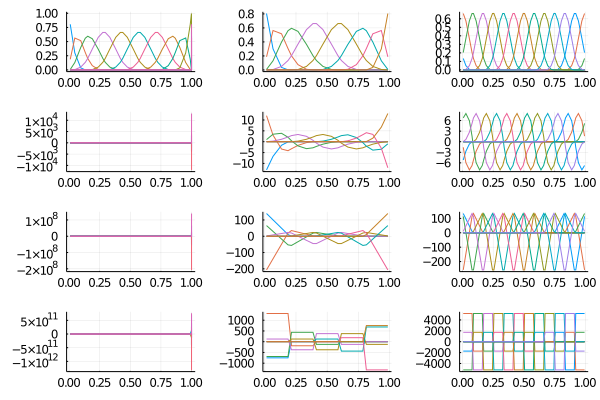

In [1070]:
# Gauss積分点上のB-spline基底関数の値
tG,wG,G = make_Gauss(P,k,N,nip)
BsG,BsG_t,BsG_tt,BsG_ttt,N,Nall = make_BsG!(dim,P,k,N,Nall,periodic_dim,tG,wG,G)

plot(
    plot(tG[1],BsG[1]',legend=false),
    plot(tG[2],BsG[2]',legend=false),
    plot(tG[3],BsG[3]',legend=false),
    plot(tG[1],BsG_t[1]',legend=false),
    plot(tG[2],BsG_t[2]',legend=false),
    plot(tG[3],BsG_t[3]',legend=false),
    plot(tG[1],BsG_tt[1]',legend=false),
    plot(tG[2],BsG_tt[2]',legend=false),
    plot(tG[3],BsG_tt[3]',legend=false),
    plot(tG[1],BsG_ttt[1]',legend=false),
    plot(tG[2],BsG_ttt[2]',legend=false),
    plot(tG[3],BsG_ttt[3]',legend=false),
    layout=(4,dim)
)

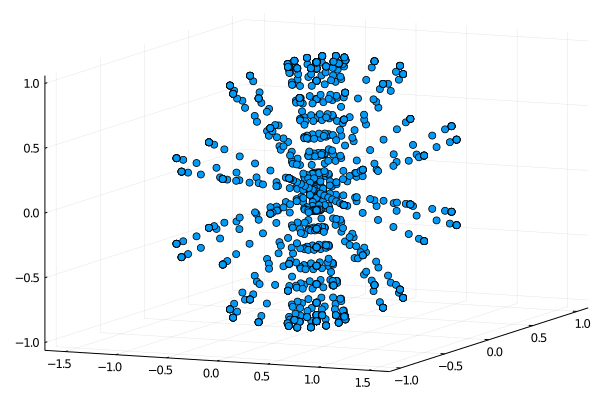

In [1071]:
# 制御点のフィッティング
a = fitting_spherical_shell(dim,P,k,N,Nall,nip,tG,wG,G,BsG,R_outside,R_ratio)
a0 = deepcopy(a)

# 評価点
tE,tEl,BsE,BsE_t,BsE_tt,BsE_ttt = make_BsE!(dim,P,k,N,Nall,periodic_dim,tEl,flag_add_knot,d₊,numE₊,border)

# 初期の制御点をプロット
plot(a0[1],a0[2],a0[3],st=:scatter,legend=false,aspect_ratio=1)

In [1072]:
####### 線形 ########################################################################

In [ ]:
@time R = calc_R_3d(dim,P,N,Nall,nip,G,BsG)
@time R_t = calc_R_t_3d(dim,P,N,Nall,nip,G,BsG,BsG_t)
@time R_tt = calc_R_tt_3d(dim,P,N,Nall,nip,G,BsG,BsG_t,BsG_tt)
#@time R_ttt = calc_R_ttt_3d(dim,P,N,Nall,nip,G,BsG,BsG_t,BsG_tt,BsG_ttt)
@time J,Jinv,detJ = calc_J_Jinv_detJ_3d(dim,P,N,Nall,nip,G,wG,a0,R_t)
@time J_t,Jinv_t = calc_J_t_Jinv_t_3d(dim,P,N,Nall,nip,G,wG,a0,R_tt,Jinv)
#@time J_tt,Jinv_tt = calc_J_tt_Jinv_tt_3d(dim,P,N,Nall,nip,G,wG,a0,base4_list,R_tt,R_ttt,Jinv,Jinv_t)
@time wG_detJ = calc_wG_detJ_3d(G,wG,detJ)
@time R_x = calc_R_x_3d(dim,P,N,Nall,nip,G,wG,R_t,Jinv)
@time R_xx = calc_R_xx_3d(dim,P,N,Nall,nip,G,wG,R_t,R_tt,Jinv,Jinv_t)
#@time R_xxx = calc_R_xxx_3d(dim,P,N,Nall,nip,G,wG,R_t,R_tt,R_ttt,Jinv,Jinv_t,Jinv_tt)
@time x_t = calc_x_t_3d(dim,P,N,Nall,nip,G,a,R_t)
@time normal,detJsrf = calc_normal_detJsrf_3d(dim,G,x_t)
#@time normal_x = calc_normal_x_3d(dim,P,k,N,Nall,tG,nip,G,a,R_t,R_tt,Jinv,normal,R_outside)
;

  0.067364 seconds (5.70 k allocations: 507.194 MiB, 8.07% gc time)
  0.151308 seconds (5.84 k allocations: 1.484 GiB, 3.25% gc time)
  0.450417 seconds (5.84 k allocations: 4.450 GiB, 1.10% gc time)


In [ ]:
function calc_normal_x_3d(dim::Int64,P::Array{Int64,1},k::Array{Array{Float64,1},1},
        N::Array{Int64,1},Nall::Int64,tG::Array{Array{Float64,1},1},nip::Array{Int64,1},
        G::Array{Int64,1},a::Array{Array{Float64,1},1},R_t::Array{Float64,5},R_tt::Array{Float64,6},
        Jinv::Array{Float64,5},normal::Array{Float64,3},R_outside::Float64)
    #x_t1 = zeros(Float64,dim,G[2],G[3])
    x_t1t = zeros(Float64,dim,dim,G[2],G[3])
    normal_x = zeros(Float64,dim,dim,G[2],G[3])
    
#     # x_t1
#     @threads for iG2 in 1:G[2]
#         supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
#         for iG3 in 1:G[3]
#             supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
#             for i in 1:dim
#                 for I1 in 1:N[1]
#                     for I2 in supp_basis_number2
#                         for I3 in supp_basis_number3
#                             I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
#                             x_t1[i,iG2,iG3] += a[i][I]*R_t[I,1,G[1],iG2,iG3]
#                         end
#                     end
#                 end
#             end
#         end
#     end
    
    # x_t1t
    @threads for iG2 in 1:G[2]
        supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
        for iG3 in 1:G[3]
            supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
            for i in 1:dim
                for k in 1:dim
                    for I1 in 1:N[1]
                        for I2 in supp_basis_number2
                            for I3 in supp_basis_number3
                                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                                x_t1t[i,k,iG2,iG3] += a[i][I]*R_tt[I,1,k,G[1],iG2,iG3]
                            end
                        end
                    end
                end
            end
        end
    end
    
    # normal_x
    @threads for iG2 in 1:G[2]
        supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
        for iG3 in 1:G[3]
            supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
            for i in 1:dim
                for j in 1:dim
                    for I1 in 1:N[1]
                        for I2 in supp_basis_number2
                            for I3 in supp_basis_number3
                                I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                                for k in 1:dim
#                                     c1_1 = 0.0
#                                     for p in 1:dim
#                                         c1_1 += x_t1[p,iG2,iG3]^2
#                                     end
#                                     c1_1 = sqrt(c1_1)
                                    
#                                     c1_2 = 0.0
#                                     for p in 1:dim
#                                         c1_2 += x_t1[p,iG2,iG3]*x_t1t[p,k,iG2,iG3]
#                                     end
                                    
#                                     c1 = x_t1t[i,k,iG2,iG3]*c1_1-x_t1[i,iG2,iG3]/c1_1*c1_2
            
#                                     c2 = 0.0
#                                     for p in 1:dim
#                                         c2 += x_t1[p,iG2,iG3]^2
#                                     end
                                    
                                    
                                    normal_x[i,j,iG2,iG3] += (Jinv[k,j,G[1],iG2,iG3]*x_t1t[i,k,iG2,iG3]/
                                                                R_outside)
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    return normal_x
end

# 変位の法線ベクトル方向成分の法線ベクトル方向の方向微分
function calc_KP_n_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},detJ::Array{Float64,3},γ::Float64,
        R::Array{Float64,4},R_x::Array{Float64,5},normal::Array{Float64,3},normal_x::Array{Float64,4})
    KP = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    c1_1 = 0.0
                                    for p in 1:dim
                                        c1_1 += R_x[I,p,G[1],iG2,iG3]*normal[p,iG2,iG3]
                                    end
                                    c1_2 = 0.0
                                    for p in 1:dim
                                        c1_2 += normal[p,iG2,iG3]*normal_x[k,p,iG2,iG3]
                                    end
                                    c1 = c1_1*normal[k,iG2,iG3]+R[I,G[1],iG2,iG3]*c1_2
                                    
                                    c2_1 = 0.0
                                    for r in 1:dim
                                        c2_1 += normal[r,iG2,iG3]*normal_x[i,r,iG2,iG3]
                                    end
                                    c2_2 = 0.0
                                    for r in 1:dim
                                        c2_2 += R_x[J,r,G[1],iG2,iG3]*normal[r,iG2,iG3]
                                    end
                                    c2 = R[J,G[1],iG2,iG3]*c2_1+c2_2*normal[i,iG2,iG3]
                                    
                                    KP[idx1,idx2] += wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*γ*c1*c2
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            KP[idx2,idx1] = KP[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return KP
end

# 変位をt1で微分する
function calc_KP_t1_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},detJ::Array{Float64,3},γ::Float64,
        a::Array{Array{Float64,1},1},R::Array{Float64,4},R_t::Array{Float64,5},
        R_tt::Array{Float64,6},normal::Array{Float64,3},R_outside::Float64)
    KP = zeros(Float64,dim*Nall,dim*Nall)
    
    normal_t1 = zeros(Float64,dim,G[2],G[3])
    
    # normal_t1
    @threads for iG2 in 1:G[2]
        supp_basis_number2 = supp_basis_number(2,P,k,N,tG[2][iG2])
        for iG3 in 1:G[3]
            supp_basis_number3 = supp_basis_number_periodic(3,P,k,N,tG[3][iG3])
            for i in 1:dim
                for I1 in 1:N[1]
                    for I2 in supp_basis_number2
                        for I3 in supp_basis_number3
                            I = (I1-1)*N[2]*N[3]+(I2-1)*N[3]+I3
                            normal_t1[i,iG2,iG3] += a[i][I]*R_tt[I,1,1,G[1],iG2,iG3]/R_outside
                        end
                    end
                end
            end
        end
    end
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    c1 = (R_t[I,1,G[1],iG2,iG3]*normal[k,iG2,iG3]+
                                            R[I,G[1],iG2,iG3]*normal_t1[k,iG2,iG3])
                                    
                                    c2 = (R_t[J,1,G[1],iG2,iG3]*normal[i,iG2,iG3]+
                                            R[J,G[1],iG2,iG3]*normal_t1[i,iG2,iG3])
                                    
                                    KP[idx1,idx2] += wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*γ*c1*c2
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            KP[idx2,idx1] = KP[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return KP
end

# 変位の法線方向の微分
function calc_KP_ux_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},detJ::Array{Float64,3},γ::Float64,
        δ::Array{Float64,2},R_x::Array{Float64,5},normal::Array{Float64,3})
    KP = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    c1 = 0.0
                                    for p in 1:dim
                                        c1 += normal[p,iG2,iG3]*R_x[I,p,G[1],iG2,iG3]
                                    end
                                    c2 = 0.0
                                    for q in 1:dim
                                        c2 += normal[q,iG2,iG3]*R_x[J,q,G[1],iG2,iG3]
                                    end
                                    KP[idx1,idx2] += (wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*
                                                        2.0*γ*δ[i,k]*c1*c2)
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            KP[idx2,idx1] = KP[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return KP
end

# 変位の法線方向の2階微分
function calc_KP_uxx_3d(dim::Int64,P::Array{Int64,1},N::Array{Int64,1},Nall::Int64,nip::Array{Int64,1},
        G::Array{Int64,1},wG::Array{Array{Float64,1},1},detJ::Array{Float64,3},γ::Float64,
        δ::Array{Float64,2},R_xx::Array{Float64,6},normal::Array{Float64,3})
    KP = zeros(Float64,dim*Nall,dim*Nall)
    
    @threads for I in 1:Nall
        I1,I2,I3 = div_I_3d(I,N)
        supp_Bs1 = supp_Bs_double(I1,1,P,N)
        supp_Bs2 = supp_Bs_double(I2,2,P,N)
        supp_Bs3 = supp_Bs_double_periodic(I3,3,P,N)
        for J1 in supp_Bs1
            supp_Gauss1 = supp_Gauss_double(I1,J1,1,P,G,nip)
            for J2 in supp_Bs2
                supp_Gauss2 = supp_Gauss_double(I2,J2,2,P,G,nip)
                for J3 in supp_Bs3
                    supp_Gauss3 = supp_Gauss_double_periodic(I3,J3,3,P,G,nip)
                    J = (J1-1)*N[2]*N[3]+(J2-1)*N[3]+J3
                    if I < J
                        break
                    end
                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            for iG2 in supp_Gauss2
                                for iG3 in supp_Gauss3
                                    c1 = 0.0
                                    for p in 1:dim
                                        for q in 1:dim
                                            c1 += (normal[p,iG2,iG3]*normal[q,iG2,iG3]*
                                                    R_xx[I,p,q,G[1],iG2,iG3])
                                        end
                                    end
                                    c2 = 0.0
                                    for p in 1:dim
                                        for q in 1:dim
                                            c2 += (normal[p,iG2,iG3]*normal[q,iG2,iG3]*
                                                    R_xx[J,p,q,G[1],iG2,iG3])
                                        end
                                    end
                                    KP[idx1,idx2] += (wG[2][iG2]*wG[3][iG3]*detJ[G[1],iG2,iG3]*
                                                        2.0*γ*δ[i,k]*c1*c2)
                                end
                            end
                        end
                    end

                    for i in 1:dim
                        for k in 1:dim
                            idx1 = (I-1)*dim+i
                            idx2 = (J-1)*dim+k
                            KP[idx2,idx1] = KP[idx1,idx2]
                        end
                    end
                end
            end
        end
    end
    return KP
end

In [ ]:
# 部分剛性行列
@time K1 = calc_K1_3d(dim,P,N,Nall,nip,G,wG_detJ,C,R_x)
@time K2 = calc_K2_3d(dim,P,N,Nall,nip,G,wG_detJ,A6,base4_list,R_xx)
;

In [ ]:
#@time K3 = calc_K3_3d(dim,P,N,Nall,nip,G,wG_detJ,A8,base6_list,R_xxx)
#@time K4 = calc_K4_3d(dim,P,N,Nall,nip,G,wG_detJ,B,base4_list,R_x,R_xxx)
#@time KP_n = calc_KP_n_3d(dim,P,N,Nall,nip,G,wG,detJ,1.0e3,R,R_x,normal,normal_x)
@time KP_ux = calc_KP_ux_3d(dim,P,N,Nall,nip,G,wG,detJ,γ_ux,δ,R_x,normal)
@time KP_uxx = calc_KP_uxx_3d(dim,P,N,Nall,nip,G,wG,detJ,γ_uxx,δ,R_xx,normal)
#@time KP = calc_KP_t1_3d(dim,P,N,Nall,nip,G,wG,detJ,γ,a,R,R_t,R_tt,normal,R_outside)

K = zeros(Float64,dim*Nall,dim*Nall)
@. K = K1+K2+KP_ux+KP_uxx
;
#heatmap(KP,yflip=true,color=:coolwarm)

In [ ]:
K1

In [ ]:
K2

In [ ]:
KP_ux

In [ ]:
KP_uxx

In [ ]:
#range_show = dim*Nall*0.7,dim*Nall
#heatmap(KP_ux,yflip=true,color=:coolwarm,xlims=range_show,ylims=range_show)

In [ ]:
#range_show = dim*Nall*0.7,dim*Nall
#heatmap(KP_uxx,yflip=true,color=:coolwarm,xlims=range_show,ylims=range_show)

In [ ]:
# 右辺ベクトル，境界条件，連立方程式
s = calc_rhs_surface_energy_3d(dim,P,N,Nall,nip,wG,G,detJsrf,b0,BsG,R_xx,normal)
#s = calc_rhs_hydrostatic_pressure(dim,P,N,Nall,nip,wG,G,detJsrf,normal,BsG)

# # Dirichlet境界条件
# range_fix = dim*N[2]*N[3]
# K[1:range_fix,:] .= 0.0
# K[:,1:range_fix] .= 0.0
# for idx in 1:range_fix
#     K[idx,idx] = 1.0
# end
# for idx in 1:range_fix
#     I,i = div_idx(dim,idx)
#     s[idx] = U[i]
# end
# for idx in range_fix:dim*Nall
#     I,i = div_idx(dim,idx)
#     s[idx] -= K[idx,1]*U[i]
# end

# # 連立方程式を解く
# ucv = zeros(Float64,dim*Nall)
# uc = [zeros(Float64,Nall) for d in 1:dim]
# ucv = K\s
# for idx in 1:dim*Nall
#     I,i = div_idx(dim,idx)
#     uc[i][I] = ucv[idx]
# end

# 両端Neumann
# Dirichlet境界条件
range_fix = dim*N[2]*N[3]-dim+1:dim*N[2]*N[3]+dim
K[range_fix,:] .= 0.0
K[:,range_fix] .= 0.0
for idx in range_fix
    K[idx,idx] = 1.0
end
for idx in range_fix
    I,i = div_idx(dim,idx)
    s[idx] = U[i]
end
for idx in 1:dim*N[2]*N[3]-dim
    I,i = div_idx(dim,idx)
    s[idx] -= K[idx,1]*U[i]
end
for idx in dim*N[2]*N[3]+dim+1:dim*Nall
    I,i = div_idx(dim,idx)
    s[idx] -= K[idx,1]*U[i]
end

# 連立方程式を解く
ucv = zeros(Float64,dim*Nall)
uc = [zeros(Float64,Nall) for d in 1:dim]
ucv = K\s
for idx in 1:dim*Nall
    I,i = div_idx(dim,idx)
    uc[i][I] = ucv[idx]
end

In [ ]:
eigvals(K)

In [ ]:
# 変位を表示する
XE,uE_lin = calc_XE_uE_3d(dim,P,k,N,tE,tEl,BsE,a0,uc)
unG_lin = calc_unG_3d(dim,P,k,N,G,a0,uc,R,R_x,R_xx,normal)
XG,uG_lin,u_xG_lin,u_xxG_lin = calc_XG_uG_3d(dim,P,k,N,G,a0,uc,R,R_x,R_xx)
plot(XE[1,:,div(tEl[2],2),1],uE_lin[1,:,div(tEl[2],2),1],legend=false,xlabel="x",ylabel="u")

In [ ]:
uE_lin[1,end,div(tEl[2],2),1]

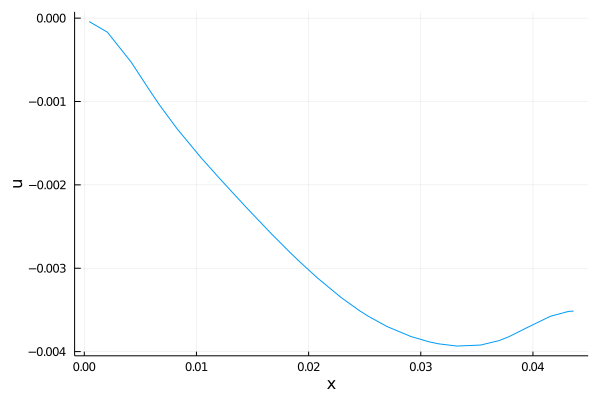

In [1064]:
plot(XG[1,:,1,1],unG_lin[:,1,1],legend=false,xlabel="x",ylabel="u")

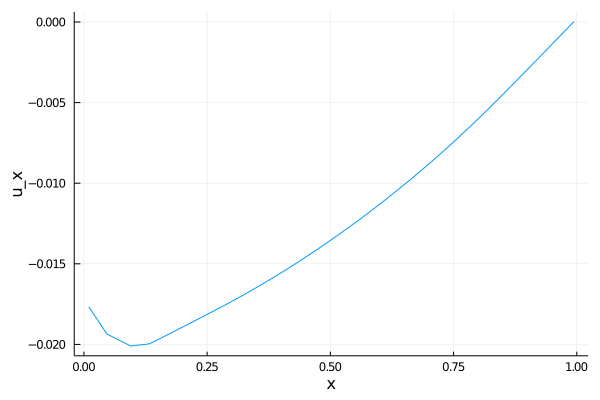

In [1065]:
plot(XG[1,:,div(G[2],2),1],u_xG_lin[1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_x")

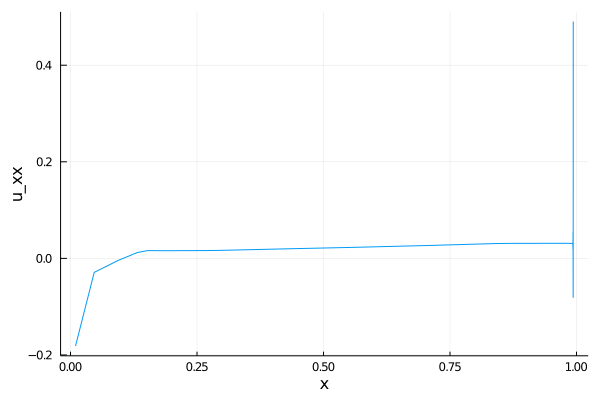

In [1066]:
plot(XG[1,:,div(G[2],2),1],u_xxG_lin[1,1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_xx")

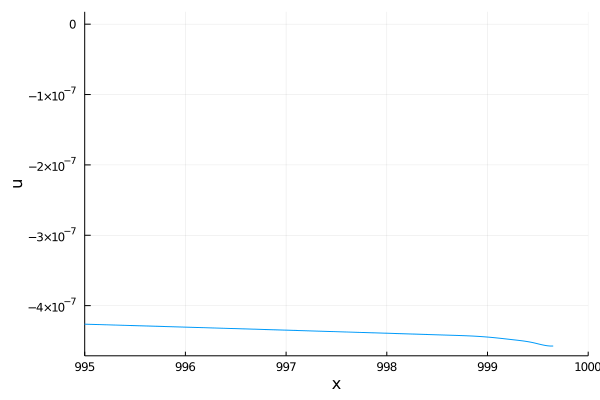

In [997]:
plot(XE[1,:,div(tEl[2],2),1],uE_lin[1,:,div(tEl[2],2),1],legend=false,xlabel="x",ylabel="u",
    xlims=(R_outside*0.995,R_outside))

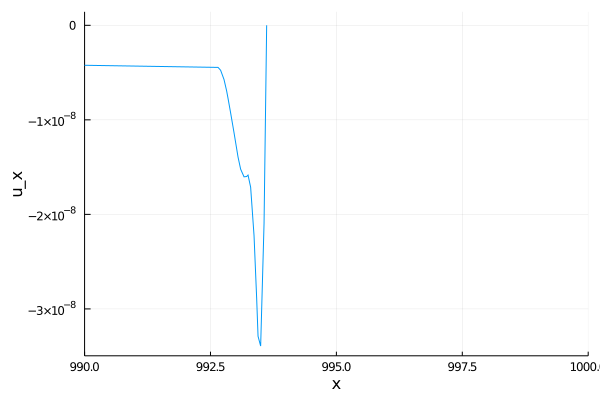

In [998]:
plot(XG[1,:,div(G[2],2),1],u_xG_lin[1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_x",
    xlims=(R_outside*0.99,R_outside))

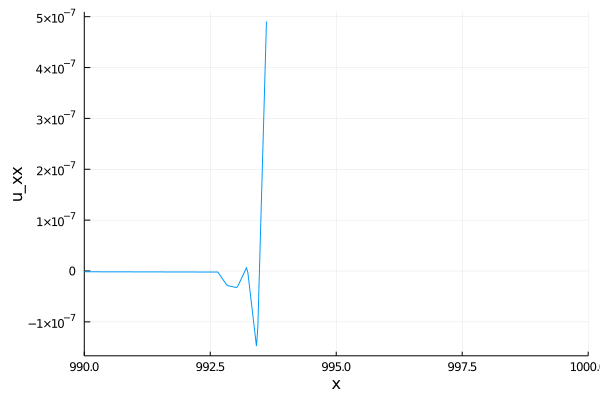

In [999]:
plot(XG[1,:,div(G[2],2),1],u_xxG_lin[1,1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_xx",
    xlims=(R_outside*0.99,R_outside))

In [1000]:
# vtkファイルを作成
vtkfile = vtk_grid("sphere_hyoumenkouka_linear",XE)
vtk_point_data(vtkfile, uE_lin, "displacement")
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "sphere_hyoumenkouka_linear.vts"

In [80]:
### 非線形 ##########################################################

In [79]:
uc

3-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0008106492771871056, 0.0008089874252480784, -0.0026058824344441685, -0.0038549261313621476, -0.002606121224341789, 0.00040804943561882694, 0.0034236939103273914, 0.004672033332838133, 0.0034243738328411837, 0.0004089810470080532]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0005710785048389454, -0.00024594007705469416, 0.002600598558198014, -0.00041360584572111347, -0.0034284827109394875, -0.004677333411385402, -0.0034292321583189707, -0.0004139844124097357, 0.002599814078510957, 0.00385002707941125]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0023097365137181567, -0.002189393382881379, 0.001711021523003504, 0.0017102798918907556, 0.0017110490346930968, 0.0017098706392013356, 0.0017106559536970406, 0.0017099623039801243, 0.0017104583589032097, 0.0017104770355573506]

In [133]:
# 線形解をニュートン法の初期値にする
for i in 1:dim
    for I in 1:Nall   
        a[i][I] += uc[i][I]
    end
end

In [82]:
s = calc_rhs_hydrostatic_pressure(dim,P,N,Nall,nip,wG,G,detJ,normal,BsG)
;

In [26]:
# 反復式
F = zeros(Float64,dim*Nall)
H = zeros(Float64,dim*Nall,dim*Nall)
Δa = zeros(Float64,dim*Nall)
@time for ν in 1:7
    Q2 = calc_Q2_3d(dim,P,N,Nall,nip,G,a,R_x)
    Q3 = calc_Q3_3d(dim,P,N,Nall,nip,G,a,R_xx)
    Q4 = calc_Q4_3d(dim,P,N,Nall,nip,G,a,R_xxx)
    x_t = calc_x_t_3d(dim,P,N,Nall,nip,G,a,R_t)
    normal = calc_normal_3d(dim,G,x_t)
    
    F1 = calc_F1_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,C,nonzero_C,base4_list,R_x,Q2)
    H1 = calc_H1_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,C,nonzero_C,base4_list,R_x,Q2)
    F2 = calc_F2_3d(dim,P,N,Nall,nip,G,wG_detJ,A6,nonzero_A6,base6_list,R_x,R_xx,Q2,Q3)
    H2 = calc_H2_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,A6,nonzero_A6,base6_list,R_x,R_xx,Q2,Q3)
    #@time F3 = calc_F3_3d(dim,P,N,Nall,nip,G,wG_detJ,A8,nonzero_A8,base8_list,R_x,R_xx,R_xxx,Q2,Q3,Q4)
    #@time H3 = calc_H3_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,A8,nonzero_A8,base8_list,R_x,R_xx,R_xxx,Q2,Q3,Q4)
    F4 = calc_F4_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,B,nonzero_B,base6_list,R_x,R_xx,R_xxx,Q2,Q3,Q4)
    H4 = calc_H4_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,B,nonzero_B,base6_list,R_x,R_xx,R_xxx,Q2,Q3,Q4)
    F5 = calc_F5_3d(dim,P,N,Nall,nip,G,wG,b0,detJ,R_x,R_xx,Q2,Q3,normal)
    H5 = calc_H5_3d(dim,P,N,Nall,nip,G,wG,δ,b0,detJ,R_x,R_xx,normal)
        
    #F = F1-s
    #H = H1
    
    @. F = F1+F2+F4+F5
    @. H = H1+H2+H4+H5
    
    # Dirichlet境界条件
    H[1:dim*N[2]*N[3],:] .= 0.0
    H[:,1:dim*N[2]*N[3]] .= 0.0
    for i in 1:dim*N[2]*N[3]
        H[i,i] = 1.0
    end
    F[1:dim*N[2]*N[3]] .= 0.0
    
    Δa = H\(-F)
    
    # aを更新
    for i in 1:dim
        for I in 1:Nall
            idx = (I-1)*dim+i
            a[i][I] += Δa[idx]
        end
    end
    
    # 収束判定
    Fnorm = sqrt(sum(F[idx]^2 for idx in 1:dim*Nall))
    anorm = sqrt(sum(Δa[idx]^2 for idx in 1:dim*Nall))
    println("ν=",ν,": Fnorm=",Fnorm,", anorm=",anorm)
    if anorm<1.0e-6
        break
    end
end

ν=1: Fnorm=4.83549016604131e6, anorm=2.7626365640073387
ν=2: Fnorm=102171.16752658873, anorm=0.5516154931979114
ν=3: Fnorm=238.9194122337178, anorm=0.016573655248350593
ν=4: Fnorm=0.18513257081880433, anorm=0.0005393764474246893
ν=5: Fnorm=0.00016054704510862076, anorm=4.6971684959901205e-5
ν=6: Fnorm=0.0001998553273387378, anorm=2.46314025532324e-5
ν=7: Fnorm=0.00027463027954984377, anorm=1.864194966909292e-5
2024.478853 seconds (11.17 M allocations: 3.109 GiB, 0.20% gc time)


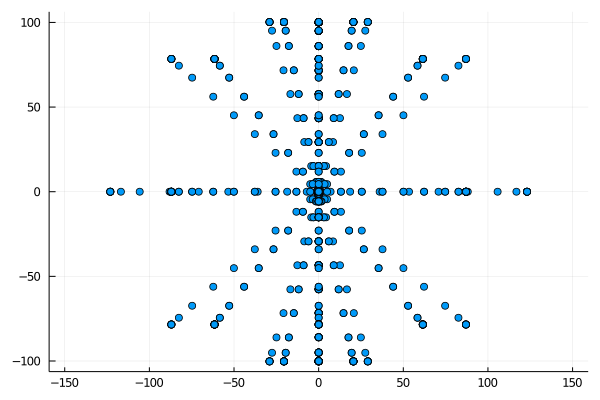

In [27]:
plot(a[1],a[3], st=:scatter,legend=false,aspect_ratio=1)

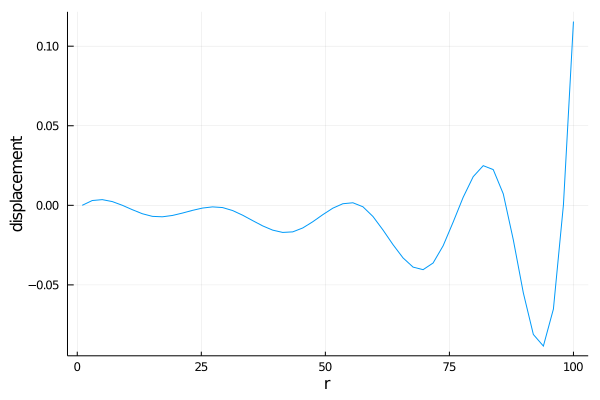

In [28]:
# 変位を表示する
x_length = collect(range(R_outside*R_ratio,R_outside,length=tEl[1]))
u_nonlinear = zeros(Float64,3,tEl[1],tEl[2],tEl[3])
x = calc_x_or_u_Evaluation(dim,P,k,N,tE,tEl,BsE,a)
u_nonlinear = x-x0
plot(x_length,u_nonlinear[1,:,div(tEl[2],2),1],legend=false,xlabel="r",ylabel="displacement")

In [29]:
u_nonlinear[1,tEl[1],div(tEl[2],2),1]/R_outside

0.0011548424638463928

In [30]:
# vtkファイルを作成
vtkfile = vtk_grid("sphere_hyoumenkouka_nonlinear", x0)
vtk_point_data(vtkfile, u_nonlinear, "displacement")
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "sphere_hyoumenkouka_nonlinear.vts"

In [31]:
# # 第2Piola-Kirchhoff応力(積分点上に値をとる)
# S = zeros(2,2,G1,G2,1)
# for nG1 in 1:G1
#     for nG2 in 1:G2
#         for i in 1:2
#             for j in 1:2
#                 for k in 1:2
#                     for l in 1:2
#                         tmp = sum(Q2[m,k,nG1,nG2]*Q2[m,l,nG1,nG2] for m in 1:2)
#                         S[i,j,nG1,nG2,1] += 1/2*C[i,j,k,l]*(tmp-δ[k,l])
#                     end
#                 end
#             end
#         end
#     end
# end

# # vtkファイルを作成
# # 第2Piola-Kirchhoff応力
# vtkfile = vtk_grid("2d_enkan_hyoumenkouka_hisenkei_kotenkou", x0) # 参考状態
# vtk_point_data(vtkfile, S[1,1,:,:,:], "S11")
# vtk_point_data(vtkfile, S[1,2,:,:,:], "S12")
# vtk_point_data(vtkfile, S[2,1,:,:,:], "S21")
# vtk_point_data(vtkfile, S[2,2,:,:,:], "S22")
# outfiles = vtk_save(vtkfile)

In [126]:
u_linear[1,tEl[1],div(tEl[2],2),1]/R_outside

-0.00026339573994870277

In [75]:
1

1

In [76]:
@code_warntype
Threads.@threads
heatmap(,yflip=true,color=:coolwarm)

LoadError: BoundsError: attempt to access ()
  at index [0]

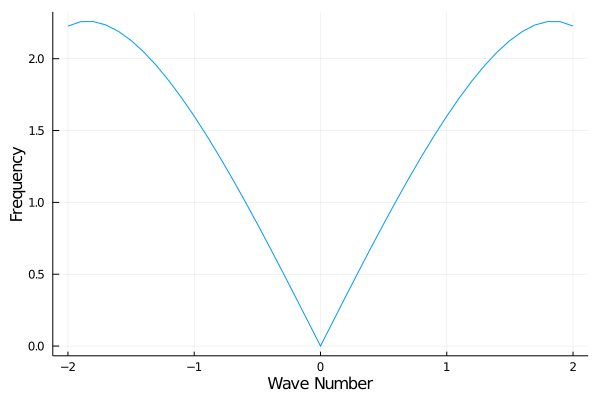

In [9]:
# フォノンの分散関係
num_k_wave = 4
k_wave = [i for i in -div(num_k_wave,2):0.1:div(num_k_wave,2)]
function dispesion_relation_SSG(k_wave,λ,μ,a1,b1,b2)
    return sqrt( (λ+2μ)*k_wave^2 + (a1-b2)*k_wave^4 + b1*k_wave^6 )
end
plot(k_wave,dispesion_relation_SSG.(k_wave,λ,μ,a1,b1,b2),xlabel="Wave Number",ylabel="Frequency",
    legend=false)